# 🏥 MIMIC-III 심부전 환자 병원 내 사망률 예측 프로젝트

## 📋 프로젝트 개요

본 연구는 **MIMIC-III 데이터베이스**를 활용하여 중환자실(ICU)에 입원한 심부전 환자의 병원 내 사망률을 예측하는 기계학습 모델을 개발하는 것을 목표로 합니다.

### 🎯 연구 목표
- **XGBoost**와 **LASSO 회귀**를 활용한 사망률 예측 모델 개발
- 독립적인 위험 요인 식별 및 예측 노모그램 구축
- 기존 GWTG-HF 위험 점수 모델과의 성능 비교

### 📊 데이터셋 정보
- **데이터 소스**: MIMIC-III 데이터베이스 (2001-2012)
- **총 환자 수**: 1,177명 (13,389명 중 선별)
- **데이터 분할**: 훈련셋(70%) vs 검증셋(30%)
- **목표 변수**: 병원 내 사망률 (outcome: 0=생존, 1=사망)

### 🔬 주요 분석 방법론
1. **데이터 전처리**: 결측치 처리 (25% 미만 변수만 사용)
2. **변수 선택**: XGBoost 중요도 + LASSO 회귀
3. **모델 구축**: 다변량 로지스틱 회귀
4. **성능 평가**: AUC, C-통계량, 보정 곡선
5. **노모그램**: 임상 의사결정 지원 도구

---


## 변수명 정리
- `group`: 데이터셋 구분
- `ID`: 환자 ID
- `outcome`: 사망 여부
- `age`: 나이
- `gendera`: 성별
- `BMI`: 체질량지수
- `hypertensive`: 고혈압 여부
- `atrialfibrillation`: 심방세동 여부
- `CHD with no MI`: 관상동맥질환 여부
- `diabetes`: 당뇨병 여부
- `deficiencyanemias`: 결핍성 빈혈 여부
- `depression`: 우울증 여부
- `Hyperlipemia`: 고지혈증 여부
- `Renal failure`: 신부전 여부
- `COPD`: 만성 폐쇄성 폐질환 여부
- `heart rate`: 심박수
- `Systolic blood pressure`: 수축기 혈압
- `Diastolic blood pressure`: 이완기 혈압
- `Respiratory rate`: 호흡수
- `temperature`: 체온
- `SP O2`: 산소포화도
- `Urine output`: 소변 배출량
- `hematocrit`: 적혈구 용적률
- `RBC`: 적혈구 수치
- `MCH`: 평균 적혈구 혈색소량
- `MCHC`: 평균 적혈구 혈색소 농도
- `MCV`: 평균 적혈구 용적
- `RDW`: 적혈구 분포 폭
- `Leucocyte`: 백혈구 수치
- `Platelets`: 혈소판 수치
- `Neutrophils`: 호중구 비율
- `Basophils`: 호염기구 비율
- `Lymphocyte`: 림프구 비율
- `PT`: 프로트롬빈 시간
- `INR`: 국제 표준화 비율
- `NT-proBNP`: 심부전 중증도
- `Creatine kinase`: 크레아틴 키나제
- `Creatinine`: 크레아티닌
- `Urea nitrogen`: 혈중 요산 질소
- `glucose`: 혈당
- `Blood potassium`: 혈중 칼륨
- `Blood sodium`: 혈중 나트륨
- `Blood calcium`: 혈중 칼슘
- `Chloride`: 염화물
- `Anion gap`: 음이온차
- `Magnesium ion`: 마그네슘 이온
- `PH`: 혈액 pH
- `Bicarbonate`: 중탄산염
- `PCO2`: 이산화탄소 분압
- `Lactic acid`: 젖산
- `EF`: 박출계수

## 📚 1. 라이브러리 임포트 및 환경 설정


In [5]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 기계학습 라이브러리
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, 
    precision_recall_curve, auc,
    brier_score_loss
)

# XGBoost
try:
    import xgboost as xgb
    print("✅ XGBoost가 성공적으로 임포트되었습니다.")
except ImportError:
    print("❌ XGBoost가 설치되지 않았습니다. 'pip install xgboost'로 설치해주세요.")

# 시각화 설정
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.unicode_minus'] = False

# 색상 팔레트 설정
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
sns.set_palette(colors)

print("🎉 모든 라이브러리가 성공적으로 임포트되었습니다!")


✅ XGBoost가 성공적으로 임포트되었습니다.
🎉 모든 라이브러리가 성공적으로 임포트되었습니다!


## 📊 2. 데이터 로딩 및 기본 정보 확인


In [6]:
# 데이터 로딩
data_path = "/Users/nogeon-u/Desktop/건양대_바이오메디컬 /numpy/numpy_project/data01.csv"
df = pd.read_csv(data_path)

print("🏥 MIMIC-III 심부전 환자 데이터 분석")
print("=" * 60)
print(f"📊 데이터셋 기본 정보:")
print(f"   • 총 환자 수: {len(df):,}명")
print(f"   • 총 변수 수: {len(df.columns)}개")
print(f"   • 데이터 크기: {df.shape}")

# 목표 변수 분포 확인
outcome_counts = df['outcome'].value_counts()
mortality_rate = df['outcome'].mean()

print(f"\n🎯 목표 변수 (outcome) 분포:")
print(f"   • 생존 (0): {outcome_counts[0]:,}명 ({(1-mortality_rate)*100:.1f}%)")
print(f"   • 사망 (1): {outcome_counts[1]:,}명 ({mortality_rate*100:.1f}%)")
print(f"   • 병원 내 사망률: {mortality_rate:.3f}")

# 훈련셋/검증셋 분포
group_counts = df['group'].value_counts().sort_index()
print(f"\n📋 데이터 분할:")
print(f"   • 훈련셋 (group=1): {group_counts[1]:,}명 ({group_counts[1]/len(df)*100:.1f}%)")
print(f"   • 검증셋 (group=2): {group_counts[2]:,}명 ({group_counts[2]/len(df)*100:.1f}%)")

# 데이터 미리보기
print(f"\n📋 데이터 미리보기:")
df.head()


🏥 MIMIC-III 심부전 환자 데이터 분석
📊 데이터셋 기본 정보:
   • 총 환자 수: 1,177명
   • 총 변수 수: 51개
   • 데이터 크기: (1177, 51)

🎯 목표 변수 (outcome) 분포:
   • 생존 (0): 1,017명 (86.5%)
   • 사망 (1): 159명 (13.5%)
   • 병원 내 사망률: 0.135

📋 데이터 분할:
   • 훈련셋 (group=1): 825명 (70.1%)
   • 검증셋 (group=2): 352명 (29.9%)

📋 데이터 미리보기:


,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [7]:
# 데이터 정보 상세 확인
print("📋 데이터 타입 및 결측치 정보:")
print("-" * 60)

# 데이터 정보
info_df = pd.DataFrame({
    '변수명': df.columns,
    '데이터타입': df.dtypes,
    '결측치수': df.isnull().sum(),
    '결측치비율(%)': (df.isnull().sum() / len(df) * 100).round(2),
    '고유값수': df.nunique()
})

# 결측치 비율로 정렬
info_df = info_df.sort_values('결측치비율(%)', ascending=False)
print(info_df.to_string(index=False))

# 결측치가 25% 이상인 변수 확인
high_missing = info_df[info_df['결측치비율(%)'] >= 25]
if len(high_missing) > 0:
    print(f"\n⚠️  결측치가 25% 이상인 변수 ({len(high_missing)}개):")
    for var in high_missing['변수명']:
        print(f"   • {var}: {high_missing[high_missing['변수명']==var]['결측치비율(%)'].values[0]:.1f}%")
else:
    print(f"\n✅ 모든 변수의 결측치 비율이 25% 미만입니다.")


📋 데이터 타입 및 결측치 정보:
------------------------------------------------------------
                     변수명   데이터타입  결측치수  결측치비율(%)  고유값수
                    PCO2 float64   294     24.98   464
                      PH float64   292     24.81   413
               Basophils float64   259     22.01    73
             Lactic acid float64   229     19.46   301
                     BMI float64   215     18.27   933
         Creatine kinase float64   165     14.02   691
              Lymphocyte float64   145     12.32   541
             Neutrophils float64   144     12.23   635
            Urine output float64    36      3.06   810
                     INR float64    20      1.70   425
                      PT float64    20      1.70   783
             temperature float64    19      1.61   775
                 glucose float64    18      1.53   802
Diastolic blood pressure float64    16      1.36  1077
 Systolic blood pressure float64    16      1.36  1102
                   SP O2 float64    13  

## 🧹 3. 데이터 전처리


In [8]:
# 데이터 전처리 함수 정의
def preprocess_data(df):
    """
    논문의 방법론에 따른 데이터 전처리
    - 결측치가 25% 이상인 변수 제외
    - 훈련/검증 데이터 분할 후 KNN 기반 결측치 대체 (데이터 누수 방지)
    """
    df_processed = df.copy()
    
    print("🧹 데이터 전처리 시작...")
    print("-" * 50)
    
    
    # 0. outcome 결측치 제거 (목표 변수)
    outcome_missing = df_processed['outcome'].isnull().sum()
    if outcome_missing > 0:
        print(f"🎯 outcome 결측치 제거: {outcome_missing}개")
        df_processed = df_processed.dropna(subset=['outcome'])
        print(f"   • 제거 전: {len(df)}명")
        print(f"   • 제거 후: {len(df_processed)}명")
    else:
        print("✅ outcome 결측치 없음")
    
    # 1. 결측치가 25% 이상인 변수 제거
    missing_threshold = 0.25
    missing_rates = df_processed.isnull().sum() / len(df_processed)
    vars_to_drop = missing_rates[missing_rates >= missing_threshold].index.tolist()
    
    if vars_to_drop:
        print(f"\n🗑️  결측치 25% 이상 변수 제거 ({len(vars_to_drop)}개):")
        for var in vars_to_drop:
            print(f"   • {var}: {missing_rates[var]*100:.1f}%")
        df_processed = df_processed.drop(columns=vars_to_drop)
    else:
        print("\n✅ 제거할 변수 없음 (모든 변수의 결측치 < 25%)")
    
    # 2. 훈련/검증 데이터 분할 (group 변수 기준)
    print(f"\n📊 훈련/검증 데이터 분할:")
    train_df = df_processed[df_processed['group'] == 1].copy()
    test_df = df_processed[df_processed['group'] == 2].copy()
    print(f"   • 훈련셋 (group=1): {len(train_df)}명")
    print(f"   • 검증셋 (group=2): {len(test_df)}명")
    
    # 3. KNN 기반 결측치 대체 (훈련 데이터로 학습 후 검증 데이터에 적용)
    print(f"\n🔧 KNN 기반 결측치 대체 처리 (데이터 누수 방지):")
    
    # 수치형 변수 식별
    numeric_vars = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    # 'group', 'ID', 'outcome' 제외
    numeric_vars = [var for var in numeric_vars if var not in ['group', 'ID', 'outcome']]
    
    # 훈련 데이터의 결측치가 있는 변수 확인
    missing_vars = []
    for var in numeric_vars:
        train_missing = train_df[var].isnull().sum()
        test_missing = test_df[var].isnull().sum()
        if train_missing > 0 or test_missing > 0:
            missing_vars.append({
                '변수명': var,
                '훈련셋_결측치': train_missing,
                '검증셋_결측치': test_missing,
                '훈련셋_비율(%)': (train_missing / len(train_df) * 100).round(2),
                '검증셋_비율(%)': (test_missing / len(test_df) * 100).round(2)
            })
    
    if missing_vars:
        print(f"📋 결측치가 있는 변수 ({len(missing_vars)}개):")
        for var_info in missing_vars:
            print(f"   • {var_info['변수명']}: 훈련셋 {var_info['훈련셋_결측치']}개 ({var_info['훈련셋_비율(%)']}%), "
                  f"검증셋 {var_info['검증셋_결측치']}개 ({var_info['검증셋_비율(%)']}%)")
        
        # KNN Imputer 적용
        from sklearn.impute import KNNImputer
        
        print(f"\n🔄 KNN Imputer 적용 중... (k=5)")
        print(f"   ⚠️  훈련 데이터로 학습 → 검증 데이터에 적용 (데이터 누수 방지)")
        
        # KNN Imputer 초기화 (k=5 사용)
        knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
        
        # 훈련 데이터로 KNN Imputer 학습 및 변환
        train_numeric = train_df[numeric_vars].copy()
        train_imputed = knn_imputer.fit_transform(train_numeric)
        train_imputed_df = pd.DataFrame(train_imputed, columns=numeric_vars, index=train_df.index)
        
        # 검증 데이터 변환 (훈련된 imputer 사용)
        test_numeric = test_df[numeric_vars].copy()
        test_imputed = knn_imputer.transform(test_numeric)
        test_imputed_df = pd.DataFrame(test_imputed, columns=numeric_vars, index=test_df.index)
        
        # 원본 데이터프레임에 대체된 값 적용
        for var in numeric_vars:
            train_df[var] = train_imputed_df[var]
            test_df[var] = test_imputed_df[var]
        
        print(f"✅ KNN 대체 완료!")
        
        # 대체 후 결측치 확인
        train_remaining = train_df[numeric_vars].isnull().sum().sum()
        test_remaining = test_df[numeric_vars].isnull().sum().sum()
        if train_remaining == 0 and test_remaining == 0:
            print(f"   • 모든 수치형 변수의 결측치가 성공적으로 대체되었습니다.")
        else:
            print(f"   • 남은 결측치 - 훈련셋: {train_remaining}개, 검증셋: {test_remaining}개")
            
    else:
        print("✅ 대체할 결측치 없음")
    
    # 4. 훈련/검증 데이터 다시 합치기
    df_processed = pd.concat([train_df, test_df], axis=0).sort_index()
    
    print(f"\n✅ 전처리 완료!")
    print(f"   • 전처리 전: {df.shape}")
    print(f"   • 전처리 후: {df_processed.shape}")
    print(f"   • 제거된 변수: {len(vars_to_drop)}개")
    print(f"   • 남은 변수: {df_processed.shape[1]}개")
    print(f"   • 훈련셋: {len(train_df)}명, 검증셋: {len(test_df)}명")
    
    return df_processed

# 전처리 실행
df_clean = preprocess_data(df)


🧹 데이터 전처리 시작...
--------------------------------------------------
🎯 outcome 결측치 제거: 1개
   • 제거 전: 1177명
   • 제거 후: 1176명

✅ 제거할 변수 없음 (모든 변수의 결측치 < 25%)

📊 훈련/검증 데이터 분할:
   • 훈련셋 (group=1): 825명
   • 검증셋 (group=2): 351명

🔧 KNN 기반 결측치 대체 처리 (데이터 누수 방지):
📋 결측치가 있는 변수 (19개):
   • BMI: 훈련셋 154개 (18.67%), 검증셋 60개 (17.09%)
   • heart rate: 훈련셋 10개 (1.21%), 검증셋 2개 (0.57%)
   • Systolic blood pressure: 훈련셋 12개 (1.45%), 검증셋 3개 (0.85%)
   • Diastolic blood pressure: 훈련셋 12개 (1.45%), 검증셋 3개 (0.85%)
   • Respiratory rate: 훈련셋 10개 (1.21%), 검증셋 2개 (0.57%)
   • temperature: 훈련셋 14개 (1.7%), 검증셋 4개 (1.14%)
   • SP O2: 훈련셋 10개 (1.21%), 검증셋 2개 (0.57%)
   • Urine output: 훈련셋 25개 (3.03%), 검증셋 10개 (2.85%)
   • Neutrophils: 훈련셋 110개 (13.33%), 검증셋 34개 (9.69%)
   • Basophils: 훈련셋 191개 (23.15%), 검증셋 68개 (19.37%)
   • Lymphocyte: 훈련셋 110개 (13.33%), 검증셋 35개 (9.97%)
   • PT: 훈련셋 12개 (1.45%), 검증셋 8개 (2.28%)
   • INR: 훈련셋 12개 (1.45%), 검증셋 8개 (2.28%)
   • Creatine kinase: 훈련셋 114개 (13.82%), 검증셋 51개 (14.53%)
   • glu

In [9]:
df_clean

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72.0,1.0,37.588179,0.0,0.0,0.0,1.0,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230000,21.166667,0.500000,40.00000,55.0
1,1,139812,0.0,75.0,2.0,30.831394,0.0,0.0,0.0,0.0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225000,33.444444,0.500000,78.00000,55.0
2,1,109787,0.0,83.0,2.0,26.572634,0.0,0.0,0.0,0.0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268000,30.571429,0.500000,71.50000,35.0
3,1,130587,0.0,43.0,2.0,83.264629,0.0,0.0,0.0,0.0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370000,38.571429,0.600000,75.00000,55.0
4,1,138290,0.0,75.0,2.0,31.824842,1.0,0.0,0.0,0.0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250000,22.000000,0.600000,50.00000,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,2,171130,0.0,62.0,1.0,25.516870,1.0,1.0,0.0,1.0,...,136.714286,10.271429,94.428571,20.142857,2.714286,7.396852,27.714286,2.087778,37.14800,40.0
1173,2,101659,0.0,78.0,1.0,25.822710,0.0,1.0,0.0,1.0,...,135.680000,10.523529,101.720000,18.160000,2.012500,7.396852,20.480000,2.087778,37.14800,30.0
1174,2,162069,0.0,85.0,2.0,23.891779,1.0,1.0,0.0,1.0,...,136.000000,8.466667,97.285714,14.000000,2.028571,7.397423,28.857143,1.547778,44.43200,55.0
1175,2,120967,0.0,79.0,2.0,35.288554,0.0,0.0,1.0,1.0,...,140.000000,8.183333,104.000000,15.750000,2.090000,7.369564,24.375000,3.487863,35.93011,25.0


In [10]:
# 훈련 데이터와 테스트 데이터 분리
train_data = df_clean[df_clean['group'] == 1].copy()
test_data = df_clean[df_clean['group'] == 2].copy()

# group과 ID 컬럼 제외
train_data = train_data.drop(columns=['group', 'ID'])
test_data = test_data.drop(columns=['group', 'ID'])

print("📊 데이터셋 분리 완료")
print("=" * 60)
print(f"훈련 데이터(train_data): {train_data.shape[0]}명, {train_data.shape[1]}개 변수")
print(f"테스트 데이터(test_data): {test_data.shape[0]}명, {test_data.shape[1]}개 변수")
print(f"\n훈련 데이터 결과 분포:")
print(train_data['outcome'].value_counts())
print(f"\n테스트 데이터 결과 분포:")
print(test_data['outcome'].value_counts())


📊 데이터셋 분리 완료
훈련 데이터(train_data): 825명, 49개 변수
테스트 데이터(test_data): 351명, 49개 변수

훈련 데이터 결과 분포:
outcome
0.0    709
1.0    116
Name: count, dtype: int64

테스트 데이터 결과 분포:
outcome
0.0    308
1.0     43
Name: count, dtype: int64


In [11]:
# age 변수의 기본 통계량 확인
print("📊 나이(age) 변수 통계량")
print("-" * 30)
print(f"평균: {df_clean['age'].mean():.2f}")
print(f"최솟값: {df_clean['age'].min():.2f}")
print(f"최댓값: {df_clean['age'].max():.2f}")
print(f"중앙값: {df_clean['age'].median():.2f}")
print(f"표준편차: {df_clean['age'].std():.2f}")


📊 나이(age) 변수 통계량
------------------------------
평균: 74.05
최솟값: 19.00
최댓값: 99.00
중앙값: 77.00
표준편차: 13.44


In [12]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1176 entries, 0 to 1176
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1176 non-null   int64  
 1   ID                        1176 non-null   int64  
 2   outcome                   1176 non-null   float64
 3   age                       1176 non-null   float64
 4   gendera                   1176 non-null   float64
 5   BMI                       1176 non-null   float64
 6   hypertensive              1176 non-null   float64
 7   atrialfibrillation        1176 non-null   float64
 8   CHD with no MI            1176 non-null   float64
 9   diabetes                  1176 non-null   float64
 10  deficiencyanemias         1176 non-null   float64
 11  depression                1176 non-null   float64
 12  Hyperlipemia              1176 non-null   float64
 13  Renal failure             1176 non-null   float64
 14  COPD         

## 📈 4. 탐색적 데이터 분석 (EDA)


In [13]:
# 4.1 기본 통계 요약
print("📊 기본 통계 요약")
print("=" * 60)

# 수치형 변수만 선택 (group, ID, outcome 제외)
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['group', 'ID', 'outcome']]

# 기본 통계량
desc_stats = df_clean[numeric_cols].describe()
print(desc_stats.round(3))


📊 기본 통계 요약
            age   gendera       BMI  hypertensive  atrialfibrillation  \
count  1176.000  1176.000  1176.000      1176.000            1176.000   
mean     74.048     1.526    30.130         0.718               0.452   
std      13.437     0.500     8.625         0.450               0.498   
min      19.000     1.000    13.347         0.000               0.000   
25%      65.000     1.000    25.095         0.000               0.000   
50%      77.000     2.000    28.563         1.000               0.000   
75%      85.000     2.000    33.166         1.000               1.000   
max      99.000     2.000   104.970         1.000               1.000   

       CHD with no MI  diabetes  deficiencyanemias  depression  Hyperlipemia  \
count        1176.000  1176.000           1176.000    1176.000      1176.000   
mean            0.086     0.421              0.339       0.119         0.380   
std             0.280     0.494              0.474       0.324         0.486   
min        

In [14]:
# 4.2 생존자 vs 사망자 그룹 비교 분석
print("\n🔍 생존자 vs 사망자 그룹 비교")
print("-" * 50)

# 그룹별 통계
survival_stats = df_clean.groupby('outcome')[numeric_cols].agg(['mean', 'std', 'median']).round(3)

# 논문에서 언급된 주요 변수들 (가능한 것들)
key_variables = [
    'age', 'BMI', 'heart rate', 'Systolic blood pressure', 'Diastolic blood pressure',
    'Respiratory rate', 'temperature', 'SP O2', 'Urine output',
    'Creatinine', 'Urea nitrogen', 'glucose', 'Blood potassium', 'Blood sodium',
    'Blood calcium', 'Anion gap', 'Lactic acid', 'PH', 'Bicarbonate', 'PCO2', 'EF',
    'NT-proBNP'
]

# 실제 존재하는 변수만 필터링
available_key_vars = [var for var in key_variables if var in df_clean.columns]

print(f"📋 주요 임상 변수별 비교 ({len(available_key_vars)}개 변수):")
print("\n생존자(0) vs 사망자(1) - 평균 ± 표준편차")
print("-" * 70)

for var in available_key_vars[:15]:  # 처음 15개만 출력
    if var in df_clean.columns:
        surv_mean = df_clean[df_clean['outcome']==0][var].mean()
        surv_std = df_clean[df_clean['outcome']==0][var].std()
        death_mean = df_clean[df_clean['outcome']==1][var].mean()
        death_std = df_clean[df_clean['outcome']==1][var].std()
        
        # t-test
        from scipy.stats import ttest_ind
        surv_data = df_clean[df_clean['outcome']==0][var].dropna()
        death_data = df_clean[df_clean['outcome']==1][var].dropna()
        
        if len(surv_data) > 0 and len(death_data) > 0:
            t_stat, p_value = ttest_ind(surv_data, death_data)
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            
            print(f"{var:25s} | 생존: {surv_mean:8.2f}±{surv_std:6.2f} | 사망: {death_mean:8.2f}±{death_std:6.2f} | p={p_value:.4f}{significance}")

print("\n* p<0.05, ** p<0.01, *** p<0.001")



🔍 생존자 vs 사망자 그룹 비교
--------------------------------------------------
📋 주요 임상 변수별 비교 (22개 변수):

생존자(0) vs 사망자(1) - 평균 ± 표준편차
----------------------------------------------------------------------
age                       | 생존:    73.71± 13.45 | 사망:    76.24± 13.22 | p=0.0270*
BMI                       | 생존:    30.37±  8.60 | 사망:    28.62±  8.65 | p=0.0176*
heart rate                | 생존:    83.78± 15.91 | 사망:    89.76± 15.22 | p=0.0000***
Systolic blood pressure   | 생존:   118.90± 17.21 | 사망:   112.21± 16.56 | p=0.0000***
Diastolic blood pressure  | 생존:    59.90± 10.84 | 사망:    57.15±  8.86 | p=0.0024**
Respiratory rate          | 생존:    20.62±  3.88 | 사망:    21.96±  4.42 | p=0.0001***
temperature               | 생존:    36.70±  0.58 | 사망:    36.53±  0.70 | p=0.0014**
SP O2                     | 생존:    96.33±  2.13 | 사망:    95.87±  3.09 | p=0.0178*


Urine output              | 생존:  1975.41±1256.07 | 사망:  1344.56±1125.88 | p=0.0000***
Creatinine                | 생존:     1.62±  1.30 | 사망:     1.79±  1.12 | p=0.1093
Urea nitrogen             | 생존:    34.54± 20.21 | 사망:    47.51± 27.96 | p=0.0000***
glucose                   | 생존:   148.04± 50.18 | 사망:   153.14± 57.34 | p=0.2431
Blood potassium           | 생존:     4.15±  0.39 | 사망:     4.32±  0.53 | p=0.0000***
Blood sodium              | 생존:   139.01±  3.98 | 사망:   138.20±  5.02 | p=0.0228*
Blood calcium             | 생존:     8.54±  0.55 | 사망:     8.24±  0.62 | p=0.0000***

* p<0.05, ** p<0.01, *** p<0.001



📊 주요 변수 시각화


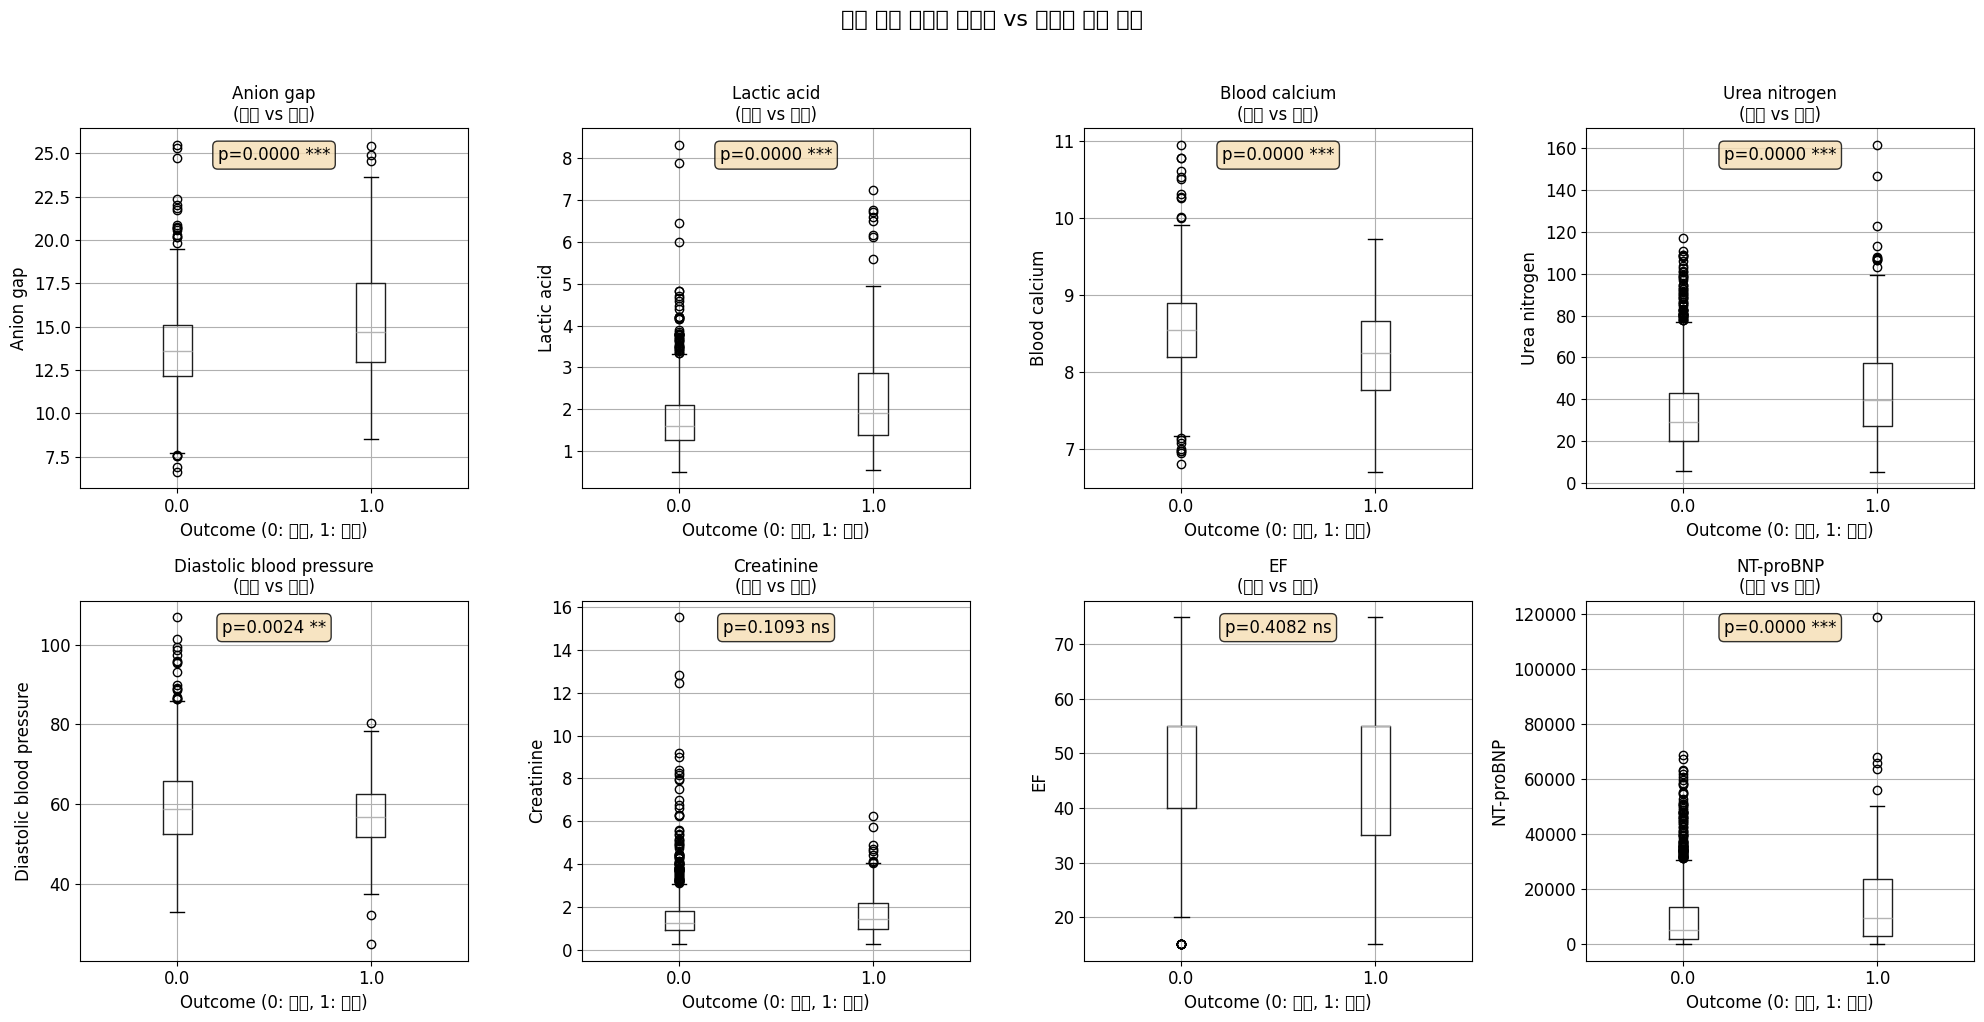

In [15]:
# 4.3 시각화 - 주요 변수 분포 비교
print("\n📊 주요 변수 시각화")

# 논문에서 중요하게 언급된 변수들 (실제 존재하는 것만)
important_vars = ['Anion gap', 'Lactic acid', 'Blood calcium', 'Urea nitrogen', 
                 'Diastolic blood pressure', 'Creatinine', 'EF', 'NT-proBNP']
important_vars = [var for var in important_vars if var in df_clean.columns]

# 4x2 서브플롯으로 시각화
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, var in enumerate(important_vars[:8]):
    if i < len(axes):
        # 박스플롯
        df_clean.boxplot(column=var, by='outcome', ax=axes[i])
        axes[i].set_title(f'{var}\n(생존 vs 사망)', fontsize=12)
        axes[i].set_xlabel('Outcome (0: 생존, 1: 사망)')
        axes[i].set_ylabel(var)
        
        # 통계적 유의성 표시
        surv_data = df_clean[df_clean['outcome']==0][var].dropna()
        death_data = df_clean[df_clean['outcome']==1][var].dropna()
        
        if len(surv_data) > 0 and len(death_data) > 0:
            from scipy.stats import ttest_ind
            t_stat, p_value = ttest_ind(surv_data, death_data)
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            axes[i].text(0.5, 0.95, f'p={p_value:.4f} {significance}', 
                        transform=axes[i].transAxes, ha='center', va='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 빈 서브플롯 숨기기
for i in range(len(important_vars), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('주요 임상 변수별 생존자 vs 사망자 분포 비교', fontsize=16, y=1.02)
plt.show()


👴 연령대별 사망률 분석
--------------------------------------------------
           총_환자수  사망자수    사망률  사망률_퍼센트
age_group                             
<50           73   9.0  0.123     12.3
50-59        118  12.0  0.102     10.2
60-69        224  22.0  0.098      9.8
70-79        293  45.0  0.154     15.4
80-89        441  64.0  0.145     14.5
90+           27   7.0  0.259     25.9


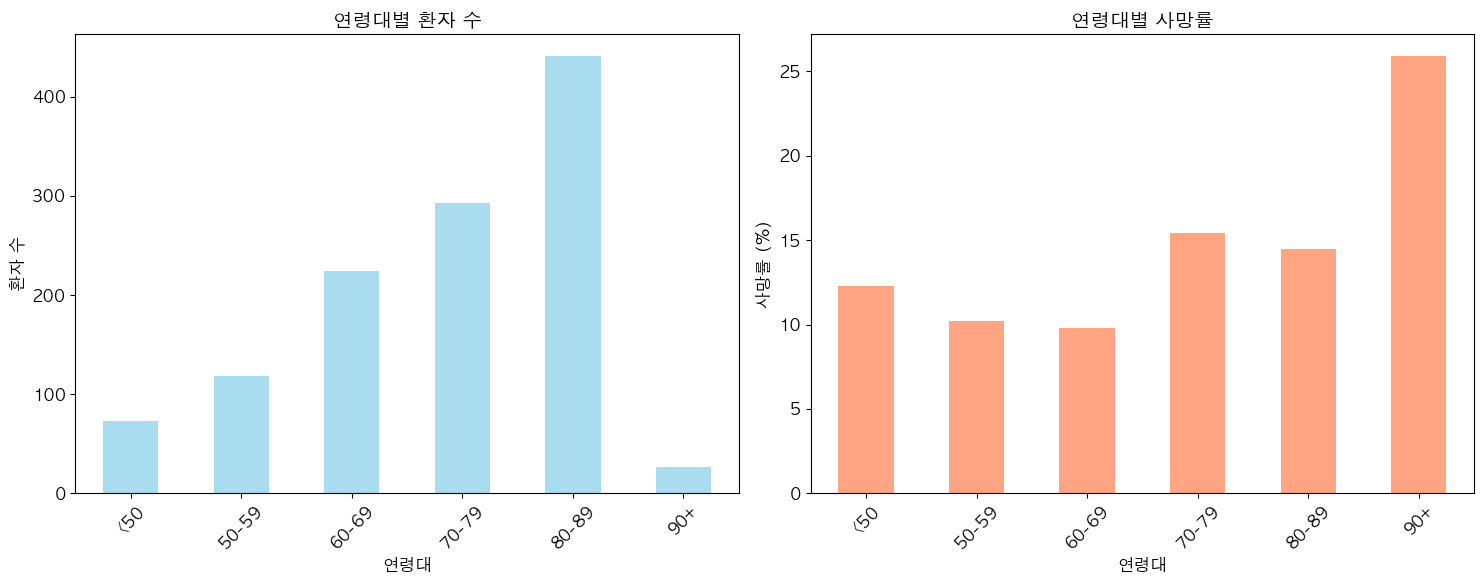

In [16]:
# 한글 폰트 설정 (맥용)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 맥에서 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 4.5.1 연령대별 사망률 분석
print("👴 연령대별 사망률 분석")
print("-" * 50)

# 연령대 구분
df_clean['age_group'] = pd.cut(df_clean['age'], 
                              bins=[0, 50, 60, 70, 80, 90, 100], 
                              labels=['<50', '50-59', '60-69', '70-79', '80-89', '90+'])

# 연령대별 사망률 계산
age_mortality = df_clean.groupby('age_group')['outcome'].agg(['count', 'sum', 'mean']).round(3)
age_mortality.columns = ['총_환자수', '사망자수', '사망률']
age_mortality['사망률_퍼센트'] = (age_mortality['사망률'] * 100).round(1)

print(age_mortality)

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 연령대별 환자 수
age_mortality['총_환자수'].plot(kind='bar', ax=ax1, color='skyblue', alpha=0.7)
ax1.set_title('연령대별 환자 수', fontsize=14)
ax1.set_xlabel('연령대')
ax1.set_ylabel('환자 수')
ax1.tick_params(axis='x', rotation=45)

# 연령대별 사망률
age_mortality['사망률_퍼센트'].plot(kind='bar', ax=ax2, color='coral', alpha=0.7)
ax2.set_title('연령대별 사망률', fontsize=14)
ax2.set_xlabel('연령대')
ax2.set_ylabel('사망률 (%)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


👫 성별에 따른 사망률 분석
--------------------------------------------------
    총_환자수  사망자수    사망률  사망률_퍼센트
남성    558  80.0  0.143     14.3
여성    618  79.0  0.128     12.8


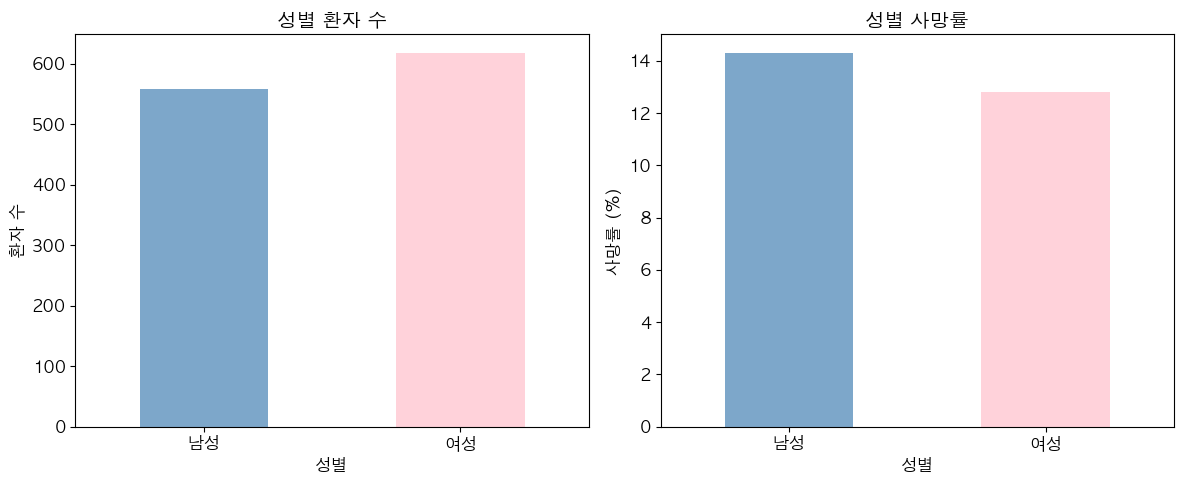

In [17]:
# 4.5.1.5 성별에 따른 사망률 분석
print("👫 성별에 따른 사망률 분석")
print("-" * 50)

# 성별별 사망률 계산
gender_mortality = df_clean.groupby('gendera')['outcome'].agg(['count', 'sum', 'mean']).round(3)
gender_mortality.columns = ['총_환자수', '사망자수', '사망률']
gender_mortality['사망률_퍼센트'] = (gender_mortality['사망률'] * 100).round(1)
gender_mortality.index = ['남성', '여성']

print(gender_mortality)

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 성별 환자 수
gender_mortality['총_환자수'].plot(kind='bar', ax=ax1, color=['steelblue', 'pink'], alpha=0.7)
ax1.set_title('성별 환자 수', fontsize=14)
ax1.set_xlabel('성별')
ax1.set_ylabel('환자 수')
ax1.tick_params(axis='x', rotation=0)

# 성별 사망률
gender_mortality['사망률_퍼센트'].plot(kind='bar', ax=ax2, color=['steelblue', 'pink'], alpha=0.7)
ax2.set_title('성별 사망률', fontsize=14)
ax2.set_xlabel('성별')
ax2.set_ylabel('사망률 (%)')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


In [18]:
# 4.5.2 동반질환별 사망률 분석
print("🏥 동반질환별 사망률 분석")
print("-" * 50)

# 동반질환 변수들 (0/1 이진 변수)
comorbidity_vars = ['hypertensive', 'atrialfibrillation', 'CHD with no MI', 'diabetes', 
                   'deficiencyanemias', 'depression', 'Hyperlipemia', 'Renal failure', 'COPD']

# 동반질환별 사망률 계산
comorbidity_analysis = []
for var in comorbidity_vars:
    if var in df_clean.columns:
        # 질환 유무별 사망률
        disease_mortality = df_clean.groupby(var)['outcome'].agg(['count', 'sum', 'mean']).round(3)
        disease_mortality.columns = ['총_환자수', '사망자수', '사망률']
        
        # 질환 있는 경우와 없는 경우 비교
        no_disease = disease_mortality.loc[0] if 0 in disease_mortality.index else pd.Series([0, 0, 0])
        has_disease = disease_mortality.loc[1] if 1 in disease_mortality.index else pd.Series([0, 0, 0])
        
        comorbidity_analysis.append({
            '질환명': var,
            '질환없음_환자수': no_disease['총_환자수'],
            '질환없음_사망률(%)': round(no_disease['사망률'] * 100, 1),
            '질환있음_환자수': has_disease['총_환자수'],
            '질환있음_사망률(%)': round(has_disease['사망률'] * 100, 1),
            '사망률_차이(%)': round((has_disease['사망률'] - no_disease['사망률']) * 100, 1)
        })

comorbidity_df = pd.DataFrame(comorbidity_analysis)
print(comorbidity_df.to_string(index=False))


🏥 동반질환별 사망률 분석
--------------------------------------------------
               질환명  질환없음_환자수  질환없음_사망률(%)  질환있음_환자수  질환있음_사망률(%)  사망률_차이(%)
      hypertensive     332.0         17.5     844.0         12.0       -5.5
atrialfibrillation     645.0         10.4     531.0         17.3        6.9
    CHD with no MI    1075.0         13.7     101.0         11.9       -1.8
          diabetes     681.0         15.0     495.0         11.5       -3.5
 deficiencyanemias     777.0         16.0     399.0          8.8       -7.2
        depression    1036.0         14.3     140.0          7.9       -6.4
      Hyperlipemia     729.0         15.0     447.0         11.2       -3.8
     Renal failure     747.0         16.3     429.0          8.6       -7.7
              COPD    1087.0         14.0      89.0          7.9       -6.1


In [19]:
df_clean.columns

Index(['group', 'ID', 'outcome', 'age', 'gendera', 'BMI', 'hypertensive',
       'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias',
       'depression', 'Hyperlipemia', 'Renal failure', 'COPD', 'heart rate',
       'Systolic blood pressure', 'Diastolic blood pressure',
       'Respiratory rate', 'temperature', 'SP O2', 'Urine output',
       'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte',
       'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR',
       'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen',
       'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium',
       'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate',
       'Lactic acid', 'PCO2', 'EF', 'age_group'],
      dtype='object')

## 🤖 5. 변수 선택 (Feature Selection)

In [20]:
# 변수 선택 (Feature Selection) 전략
print("🎯 변수 선택 전략 수립")
print("=" * 80)

# 1. 불필요한 변수 제거 (ID, group 등)
print("\n1️⃣ 불필요한 변수 제거")
print("-" * 80)
unnecessary_cols = ['group', 'ID', 'age_group']  # ID, 그룹 변수 등
print(f"제거할 변수: {unnecessary_cols}")

# 2. 상관관계 기반 변수 선택
print("\n2️⃣ 상관관계 기반 변수 선택")
print("-" * 80)

# outcome과의 상관관계 계산
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
# 불필요한 변수 제외
numeric_cols = [col for col in numeric_cols if col not in unnecessary_cols and col != 'outcome']

correlation_with_outcome = df_clean[numeric_cols + ['outcome']].corr()['outcome'].drop('outcome')
correlation_with_outcome = correlation_with_outcome.abs().sort_values(ascending=False)

print(f"📊 outcome과의 상관관계 (절댓값 기준 상위 15개):")
for i, (var, corr) in enumerate(correlation_with_outcome.head(15).items(), 1):
    print(f"{i:2d}. {var:30s}: {corr:6.3f}")

# 3. 다양한 임계값으로 변수 선택 시뮬레이션
print("\n3️⃣ 상관관계 임계값별 변수 개수")
print("-" * 80)
thresholds = [0.05, 0.08, 0.10, 0.12, 0.15, 0.20]
for threshold in thresholds:
    selected_vars = correlation_with_outcome[correlation_with_outcome >= threshold].index.tolist()
    print(f"임계값 {threshold:.2f}: {len(selected_vars):2d}개 변수 선택")

# 4. 권장 변수 선택 (상관관계 0.1 이상)
print("\n4️⃣ 권장 변수 선택 (상관관계 ≥ 0.10)")
print("-" * 80)
selected_features = correlation_with_outcome[correlation_with_outcome >= 0.10].index.tolist()
print(f"✅ 선택된 변수: {len(selected_features)}개")
print("\n선택된 변수 목록:")
for i, var in enumerate(selected_features, 1):
    corr_value = correlation_with_outcome[var]
    print(f"{i:2d}. {var:30s}: {corr_value:6.3f}")

# 5. 선택된 변수로 데이터셋 구성
print("\n5️⃣ 최종 데이터셋 구성")
print("-" * 80)
df_selected = df_clean[selected_features + ['outcome']].copy()
print(f"📦 최종 데이터셋 크기: {df_selected.shape}")
print(f"   - 샘플 수: {df_selected.shape[0]}")
print(f"   - 특성 변수: {df_selected.shape[1] - 1}개")
print(f"   - 목표 변수: 1개 (outcome)")

# 6. 다중공선성 확인 (선택된 변수들 간의 상관관계)
print("\n6️⃣ 다중공선성 확인 (선택된 변수들 간 상관관계)")
print("-" * 80)
selected_corr_matrix = df_selected[selected_features].corr()

# 높은 상관관계를 가진 변수 쌍 찾기
high_corr_pairs = []
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        corr_value = abs(selected_corr_matrix.iloc[i, j])
        if corr_value > 0.7:  # 0.7 이상이면 높은 상관관계
            high_corr_pairs.append((selected_features[i], selected_features[j], corr_value))

if high_corr_pairs:
    print(f"⚠️  높은 상관관계(>0.7)를 가진 변수 쌍: {len(high_corr_pairs)}개")
    for var1, var2, corr in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
        print(f"   - {var1:25s} ↔ {var2:25s}: {corr:.3f}")
    print("\n💡 다중공선성 해결 방안:")
    print("   1. 상관관계가 높은 변수 중 하나 제거")
    print("   2. PCA 등 차원 축소 기법 적용")
    print("   3. 정규화 기법(Ridge, Lasso) 사용")
else:
    print("✅ 다중공선성 문제 없음 (모든 변수 쌍의 상관관계 < 0.7)")

print("\n" + "=" * 80)
print("📌 변수 선택 완료!")
print(f"   최종 선택된 변수: {len(selected_features)}개")
print(f"   다음 단계: 스케일링 및 모델 학습")
print("=" * 80)


🎯 변수 선택 전략 수립

1️⃣ 불필요한 변수 제거
--------------------------------------------------------------------------------
제거할 변수: ['group', 'ID', 'age_group']

2️⃣ 상관관계 기반 변수 선택
--------------------------------------------------------------------------------
📊 outcome과의 상관관계 (절댓값 기준 상위 15개):
 1. Anion gap                     :  0.230
 2. Bicarbonate                   :  0.223
 3. Leucocyte                     :  0.208
 4. Lactic acid                   :  0.208
 5. Urea nitrogen                 :  0.203
 6. Blood calcium                 :  0.184
 7. Urine output                  :  0.172
 8. RDW                           :  0.148
 9. PH                            :  0.144
10. INR                           :  0.144
11. PT                            :  0.140
12. Blood potassium               :  0.137
13. Systolic blood pressure       :  0.132
14. Lymphocyte                    :  0.129
15. heart rate                    :  0.128

3️⃣ 상관관계 임계값별 변수 개수
----------------------------------------------------

In [21]:
# 추가 변수 선택 (19개 → 최종 변수)
print("\n" + "=" * 80)
print("🔍 2단계: 추가 변수 선택 (Feature Selection)")
print("=" * 80)

# 방법 1: VIF (Variance Inflation Factor)를 이용한 다중공선성 제거
print("\n1️⃣ VIF(분산팽창계수)를 이용한 다중공선성 제거")
print("-" * 80)
print("💡 VIF > 10: 심각한 다중공선성")
print("💡 VIF > 5: 주의가 필요한 다중공선성")

from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계산
X_for_vif = df_selected[selected_features].copy()
vif_data = pd.DataFrame()
vif_data["변수명"] = X_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_for_vif.values, i) for i in range(len(X_for_vif.columns))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\n📊 VIF 분석 결과:")
print(vif_data.to_string(index=False))

# VIF > 10인 변수 제거
high_vif_vars = vif_data[vif_data['VIF'] > 10]['변수명'].tolist()
if high_vif_vars:
    print(f"\n⚠️  VIF > 10인 변수: {len(high_vif_vars)}개")
    for var in high_vif_vars:
        vif_value = vif_data[vif_data['변수명'] == var]['VIF'].values[0]
        print(f"   - {var}: {vif_value:.2f}")
    
    # VIF가 높은 변수 제거
    selected_features_vif = [var for var in selected_features if var not in high_vif_vars]
    print(f"\n✅ VIF 기준 선택된 변수: {len(selected_features_vif)}개")
else:
    selected_features_vif = selected_features.copy()
    print("\n✅ 모든 변수의 VIF < 10 (다중공선성 문제 없음)")

# 방법 2: Random Forest Feature Importance
print("\n2️⃣ Random Forest Feature Importance")
print("-" * 80)
from sklearn.ensemble import RandomForestClassifier

X_rf = df_selected[selected_features_vif]
y_rf = df_selected['outcome']

rf_model = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=5)
rf_model.fit(X_rf, y_rf)

# Feature Importance 계산
feature_importance = pd.DataFrame({
    '변수명': selected_features_vif,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Feature Importance 순위:")
print(feature_importance.to_string(index=False))

# 상위 12-15개 변수 선택 (누적 중요도 90% 기준)
cumsum_importance = feature_importance['Importance'].cumsum()
n_features_90 = (cumsum_importance <= 0.90).sum() + 1

print(f"\n💡 누적 중요도 90% 달성: 상위 {n_features_90}개 변수")

# 방법 3: Recursive Feature Elimination (RFE)
print("\n3️⃣ RFE (Recursive Feature Elimination)")
print("-" * 80)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# 최적 변수 개수 설정 (10-15개 사이)
n_features_to_select = min(12, len(selected_features_vif))

rfe_model = RFE(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_features_to_select=n_features_to_select
)
rfe_model.fit(X_rf, y_rf)

# RFE 결과
rfe_results = pd.DataFrame({
    '변수명': selected_features_vif,
    '선택여부': rfe_model.support_,
    '순위': rfe_model.ranking_
}).sort_values('순위')

print(f"\n📊 RFE 선택 결과 (목표: {n_features_to_select}개):")
print(rfe_results.to_string(index=False))

selected_features_rfe = rfe_results[rfe_results['선택여부'] == True]['변수명'].tolist()

# 최종 변수 선택: 3가지 방법의 교집합 또는 다수결
print("\n4️⃣ 최종 변수 선택 (종합)")
print("-" * 80)

# Feature Importance 상위 변수
top_importance_vars = feature_importance.head(n_features_to_select)['변수명'].tolist()

# 3가지 방법 비교
print("\n📊 각 방법별 선택 변수:")
print(f"   1. VIF 기준: {len(selected_features_vif)}개")
print(f"   2. Feature Importance 상위: {len(top_importance_vars)}개")
print(f"   3. RFE 선택: {len(selected_features_rfe)}개")

# 2개 이상의 방법에서 선택된 변수 (다수결)
from collections import Counter

all_selected = selected_features_vif + top_importance_vars + selected_features_rfe
vote_count = Counter(all_selected)

# 2표 이상 받은 변수
final_features = [var for var, count in vote_count.items() if count >= 2]

print(f"\n✅ 최종 선택 변수 (2개 이상 방법에서 선택): {len(final_features)}개")
print("\n최종 변수 목록:")
for i, var in enumerate(final_features, 1):
    votes = vote_count[var]
    corr_value = correlation_with_outcome[var]
    importance = feature_importance[feature_importance['변수명'] == var]['Importance'].values[0] if var in feature_importance['변수명'].values else 0
    print(f"{i:2d}. {var:30s} | 득표: {votes}/3 | 상관계수: {corr_value:6.3f} | 중요도: {importance:.4f}")

# 최종 데이터셋 구성
df_final = df_clean[final_features + ['outcome']].copy()

print("\n" + "=" * 80)
print("📌 최종 변수 선택 완료!")
print(f"   초기 변수: {len(selected_features)}개 → 최종 변수: {len(final_features)}개")
print(f"   최종 데이터셋 크기: {df_final.shape}")
print("=" * 80)

# 선택된 변수를 다음 단계에서 사용하기 위해 저장
selected_features = final_features
df_selected = df_final.copy()



🔍 2단계: 추가 변수 선택 (Feature Selection)

1️⃣ VIF(분산팽창계수)를 이용한 다중공선성 제거
--------------------------------------------------------------------------------
💡 VIF > 10: 심각한 다중공선성
💡 VIF > 5: 주의가 필요한 다중공선성

📊 VIF 분석 결과:
                    변수명        VIF
                     PH 532.544086
          Blood calcium 293.164790
                     PT 258.468573
                    INR 186.157057
        Blood potassium 115.185459
              Anion gap  74.248030
                    RDW  64.480668
Systolic blood pressure  54.728887
            Bicarbonate  54.526504
             heart rate  37.183222
       Respiratory rate  34.148412
          Urea nitrogen   7.080310
            Lactic acid   6.668100
              Leucocyte   6.555188
             Lymphocyte   3.896014
           Urine output   3.883480
              NT-proBNP   2.249603
     atrialfibrillation   2.130083
          Renal failure   2.084406

⚠️  VIF > 10인 변수: 11개
   - PH: 532.54
   - Blood calcium: 293.16
   - PT: 258.47
   - INR

In [22]:
df_selected

,Leucocyte,Lactic acid,Urea nitrogen,Urine output,Lymphocyte,NT-proBNP,Renal failure,atrialfibrillation,outcome
0,7.650000,0.500000,50.000000,2155.0,13.300000,1956.0,1.0,0.0,0.0
1,12.740000,0.500000,20.333333,1425.0,9.980000,2384.0,0.0,0.0,0.0
2,5.480000,0.500000,33.857143,2425.0,24.500000,4081.0,1.0,0.0,0.0
3,8.225000,0.600000,15.285714,8760.0,14.500000,668.0,0.0,0.0,0.0
4,8.833333,0.600000,43.000000,4455.0,10.523333,30802.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1172,7.742857,2.087778,48.000000,1223.6,10.650000,47985.0,1.0,1.0,0.0
1173,22.309091,2.087778,34.500000,1223.6,7.700000,48044.0,1.0,1.0,0.0
1174,9.228571,1.547778,30.428571,118.0,24.400000,50976.0,1.0,1.0,0.0
1175,6.062500,3.487863,35.500000,2585.0,13.200000,59701.0,1.0,0.0,0.0


In [23]:
train_data

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,0.0,72.0,1.0,37.588179,0.0,0.0,0.0,1.0,1.0,0.0,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230000,21.166667,0.500000,40.000000,55.0
1,0.0,75.0,2.0,30.831394,0.0,0.0,0.0,0.0,1.0,0.0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225000,33.444444,0.500000,78.000000,55.0
2,0.0,83.0,2.0,26.572634,0.0,0.0,0.0,0.0,1.0,0.0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268000,30.571429,0.500000,71.500000,35.0
3,0.0,43.0,2.0,83.264629,0.0,0.0,0.0,0.0,0.0,0.0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370000,38.571429,0.600000,75.000000,55.0
4,0.0,75.0,2.0,31.824842,1.0,0.0,0.0,0.0,1.0,0.0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250000,22.000000,0.600000,50.000000,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,0.0,64.0,1.0,23.799788,1.0,0.0,0.0,1.0,0.0,0.0,...,141.600000,8.440000,98.200000,17.400000,1.980000,7.388648,30.600000,2.518974,45.540000,35.0
821,0.0,35.0,2.0,25.785124,0.0,0.0,0.0,0.0,1.0,0.0,...,136.000000,8.055556,105.888889,14.222222,2.090000,7.388648,20.222222,2.518974,40.411238,35.0
822,0.0,89.0,2.0,22.333423,0.0,0.0,0.0,1.0,1.0,0.0,...,138.000000,9.537500,97.454545,16.909091,2.214286,7.369564,28.000000,3.267863,37.304777,25.0
823,0.0,77.0,1.0,28.564343,1.0,1.0,0.0,0.0,1.0,0.0,...,137.625000,9.025000,95.000000,18.125000,2.100000,7.363849,28.750000,2.930101,38.281026,50.0


In [24]:
test_data

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
825,0.0,38.0,2.0,26.251235,0.0,0.0,0.0,0.0,0.0,0.0,...,141.250000,7.912500,107.000000,12.285714,1.800000,7.240000,26.555556,0.500000,48.608000,55.0
826,1.0,53.0,2.0,25.418469,1.0,0.0,0.0,1.0,1.0,0.0,...,128.428571,8.138462,91.357143,13.714286,2.738462,7.216364,28.285714,0.533333,76.272727,55.0
827,0.0,66.0,2.0,29.349580,1.0,0.0,0.0,1.0,1.0,0.0,...,137.454545,7.763636,104.272727,14.454545,2.125000,7.360000,22.545455,0.600000,35.000000,55.0
828,0.0,58.0,1.0,38.809877,0.0,1.0,0.0,1.0,0.0,0.0,...,140.200000,9.200000,103.100000,13.800000,2.288889,7.437500,27.200000,0.600000,44.375000,55.0
829,0.0,65.0,2.0,41.363963,1.0,0.0,0.0,1.0,0.0,0.0,...,140.111111,9.500000,101.666667,14.000000,2.057143,7.320000,29.125000,0.733333,46.000000,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0.0,62.0,1.0,25.516870,1.0,1.0,0.0,1.0,0.0,1.0,...,136.714286,10.271429,94.428571,20.142857,2.714286,7.396852,27.714286,2.087778,37.148000,40.0
1173,0.0,78.0,1.0,25.822710,0.0,1.0,0.0,1.0,0.0,1.0,...,135.680000,10.523529,101.720000,18.160000,2.012500,7.396852,20.480000,2.087778,37.148000,30.0
1174,0.0,85.0,2.0,23.891779,1.0,1.0,0.0,1.0,1.0,0.0,...,136.000000,8.466667,97.285714,14.000000,2.028571,7.397423,28.857143,1.547778,44.432000,55.0
1175,0.0,79.0,2.0,35.288554,0.0,0.0,1.0,1.0,1.0,1.0,...,140.000000,8.183333,104.000000,15.750000,2.090000,7.369564,24.375000,3.487863,35.930110,25.0


In [25]:
# train_data와 test_data에서 df_selected의 컬럼만 선택
print("🔧 train_data와 test_data 컬럼 선택")
print("=" * 60)

# df_selected의 컬럼 목록 (outcome 제외)
selected_columns = [col for col in df_selected.columns if col != 'outcome']

print(f"📋 선택할 컬럼 수: {len(selected_columns)}개")
print(f"   컬럼 목록: {selected_columns}")

# train_data와 test_data에서 선택된 컬럼만 추출
train_data_selected = train_data[selected_columns + ['outcome']].copy()
test_data_selected = test_data[selected_columns + ['outcome']].copy()

print(f"\n✅ 컬럼 선택 완료!")
print(f"   train_data: {train_data.shape} → {train_data_selected.shape}")
print(f"   test_data: {test_data.shape} → {test_data_selected.shape}")

# 기존 변수 업데이트
train_data = train_data_selected
test_data = test_data_selected

print("\n" + "=" * 60)


🔧 train_data와 test_data 컬럼 선택
📋 선택할 컬럼 수: 8개
   컬럼 목록: ['Leucocyte', 'Lactic acid', 'Urea nitrogen', 'Urine output', 'Lymphocyte', 'NT-proBNP', 'Renal failure', 'atrialfibrillation']

✅ 컬럼 선택 완료!
   train_data: (825, 49) → (825, 9)
   test_data: (351, 49) → (351, 9)



In [26]:
train_data

,Leucocyte,Lactic acid,Urea nitrogen,Urine output,Lymphocyte,NT-proBNP,Renal failure,atrialfibrillation,outcome
0,7.650000,0.500000,50.000000,2155.0,13.300000,1956.0,1.0,0.0,0.0
1,12.740000,0.500000,20.333333,1425.0,9.980000,2384.0,0.0,0.0,0.0
2,5.480000,0.500000,33.857143,2425.0,24.500000,4081.0,1.0,0.0,0.0
3,8.225000,0.600000,15.285714,8760.0,14.500000,668.0,0.0,0.0,0.0
4,8.833333,0.600000,43.000000,4455.0,10.523333,30802.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
820,8.425000,2.518974,25.400000,1652.0,13.400000,54783.0,1.0,0.0,0.0
821,14.090000,2.518974,46.900000,1660.0,5.550000,55060.0,0.0,0.0,0.0
822,5.628571,3.267863,83.090909,1850.0,16.450000,58433.0,1.0,0.0,0.0
823,3.120000,2.930101,29.333333,991.8,15.900000,67231.0,1.0,1.0,0.0


## 🔄 6. SMOTE 데이터 증강 (불균형 데이터 해결)


In [27]:
# imblearn 라이브러리 설치
import subprocess
import sys

try:
    # imblearn 설치 시도
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
    print("✅ imbalanced-learn 패키지가 성공적으로 설치되었습니다!")
except Exception as e:
    print(f"❌ 설치 중 오류 발생: {e}")

# 필요한 라이브러리 임포트
try:
    from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    import warnings
    warnings.filterwarnings('ignore')
    
    print("✅ SMOTE 관련 라이브러리가 성공적으로 임포트되었습니다!")
except ImportError as e:
    print(f"❌ 라이브러리 임포트 실패: {e}")
    print("💡 Jupyter 노트북을 재시작한 후 다시 시도해주세요.")


✅ imbalanced-learn 패키지가 성공적으로 설치되었습니다!
✅ SMOTE 관련 라이브러리가 성공적으로 임포트되었습니다!



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [28]:
train_data

,Leucocyte,Lactic acid,Urea nitrogen,Urine output,Lymphocyte,NT-proBNP,Renal failure,atrialfibrillation,outcome
0,7.650000,0.500000,50.000000,2155.0,13.300000,1956.0,1.0,0.0,0.0
1,12.740000,0.500000,20.333333,1425.0,9.980000,2384.0,0.0,0.0,0.0
2,5.480000,0.500000,33.857143,2425.0,24.500000,4081.0,1.0,0.0,0.0
3,8.225000,0.600000,15.285714,8760.0,14.500000,668.0,0.0,0.0,0.0
4,8.833333,0.600000,43.000000,4455.0,10.523333,30802.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
820,8.425000,2.518974,25.400000,1652.0,13.400000,54783.0,1.0,0.0,0.0
821,14.090000,2.518974,46.900000,1660.0,5.550000,55060.0,0.0,0.0,0.0
822,5.628571,3.267863,83.090909,1850.0,16.450000,58433.0,1.0,0.0,0.0
823,3.120000,2.930101,29.333333,991.8,15.900000,67231.0,1.0,1.0,0.0


In [29]:
test_data

,Leucocyte,Lactic acid,Urea nitrogen,Urine output,Lymphocyte,NT-proBNP,Renal failure,atrialfibrillation,outcome
825,4.485714,0.500000,9.875000,1350.0,7.40,4842.0,0.0,0.0,0.0
826,7.440000,0.533333,91.642857,1769.0,17.20,30307.0,1.0,0.0,1.0
827,5.520000,0.600000,60.000000,3690.0,10.30,3050.0,1.0,0.0,0.0
828,7.887500,0.600000,68.400000,707.0,16.40,8628.0,1.0,1.0,0.0
829,8.166667,0.733333,32.125000,5900.0,17.35,1443.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1172,7.742857,2.087778,48.000000,1223.6,10.65,47985.0,1.0,1.0,0.0
1173,22.309091,2.087778,34.500000,1223.6,7.70,48044.0,1.0,1.0,0.0
1174,9.228571,1.547778,30.428571,118.0,24.40,50976.0,1.0,1.0,0.0
1175,6.062500,3.487863,35.500000,2585.0,13.20,59701.0,1.0,0.0,0.0


In [30]:
# 🔄 훈련/테스트 데이터 분리 (X, y)
print("📊 데이터 분리 중...")

# 훈련 데이터 분리
X_train = train_data.drop(columns=['outcome'])  # 독립변수 (특성)
y_train = train_data['outcome']  # 종속변수 (결과)

# 테스트 데이터 분리
X_test = test_data.drop(columns=['outcome'])  # 독립변수 (특성)
y_test = test_data['outcome']  # 종속변수 (결과)

print("✅ 데이터 분리 완료!")
print(f"\n📈 훈련 데이터:")
print(f"   - X_train 크기: {X_train.shape} (샘플 수: {X_train.shape[0]}, 특성 수: {X_train.shape[1]})")
print(f"   - y_train 크기: {y_train.shape}")
print(f"   - 생존 환자: {sum(y_train == 0)}명")
print(f"   - 사망 환자: {sum(y_train == 1)}명")

print(f"\n📉 테스트 데이터:")
print(f"   - X_test 크기: {X_test.shape} (샘플 수: {X_test.shape[0]}, 특성 수: {X_test.shape[1]})")
print(f"   - y_test 크기: {y_test.shape}")
print(f"   - 생존 환자: {sum(y_test == 0)}명")
print(f"   - 사망 환자: {sum(y_test == 1)}명")


📊 데이터 분리 중...
✅ 데이터 분리 완료!

📈 훈련 데이터:
   - X_train 크기: (825, 8) (샘플 수: 825, 특성 수: 8)
   - y_train 크기: (825,)
   - 생존 환자: 709명
   - 사망 환자: 116명

📉 테스트 데이터:
   - X_test 크기: (351, 8) (샘플 수: 351, 특성 수: 8)
   - y_test 크기: (351,)
   - 생존 환자: 308명
   - 사망 환자: 43명


🔄 하이브리드 샘플링 (언더샘플링 + SMOTE) 적용 중...
📊 원본 훈련셋 분포:
   - 총 훈련 데이터: 825명
   - 생존 환자 (다수 클래스): 709명
   - 사망 환자 (소수 클래스): 116명
   - 불균형 비율: 6.1:1

🔽 1단계: 언더샘플링
   - 목표 생존 환자 수: 354명 (원본의 50%)
   - 언더샘플링 후 생존 환자: 354명
   - 언더샘플링 후 사망 환자: 116명
   - 새로운 불균형 비율: 3.1:1

🔼 2단계: SMOTE 오버샘플링
   - 목표 사망 환자 수: 354명 (생존 환자와 동일)
✅ 하이브리드 샘플링 완료!

📊 최종 데이터 분포:
   - 원본 훈련셋: 825명
   - 최종 훈련셋: 708명
   - 데이터 변화량: -117명
   - 변수 개수: 8개

🎯 최종 클래스별 분포:
   - 생존 (0): 354명 (50.0%)
   - 사망 (1): 354명 (50.0%)
   - 균형 비율: 1:1 (완벽한 균형)


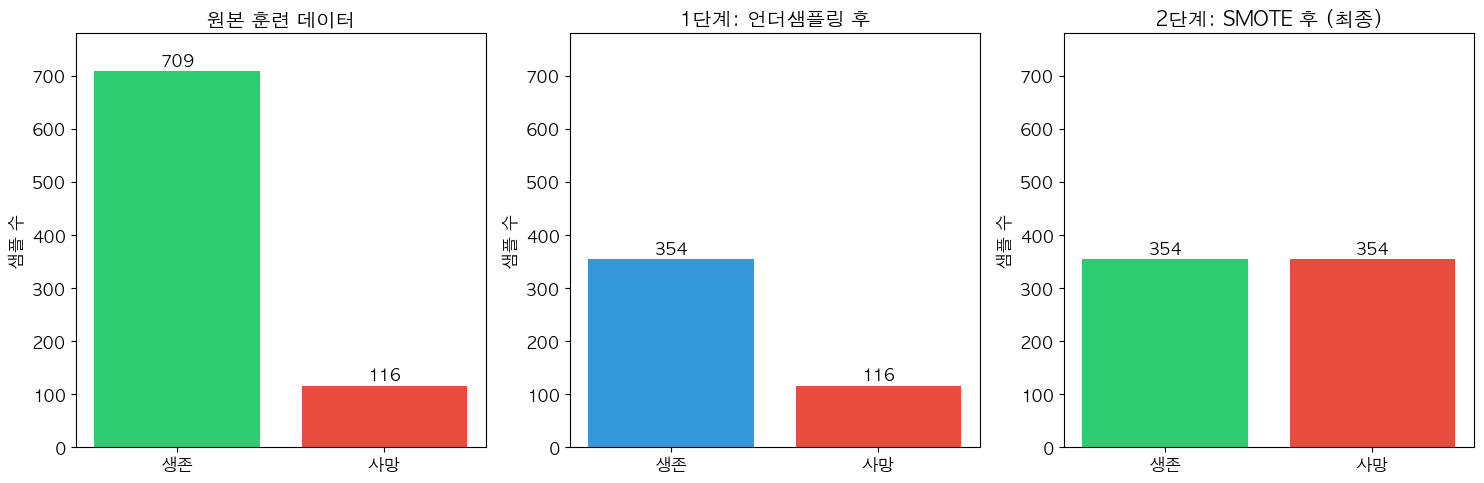


💡 하이브리드 샘플링의 장점:
   1. 언더샘플링으로 다수 클래스의 정보 손실 최소화
   2. SMOTE로 소수 클래스의 다양성 확보
   3. 완벽한 클래스 균형으로 모델 학습 최적화


In [31]:
# 하이브리드 샘플링: RandomUnderSampler + SMOTE 조합
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

print("🔄 하이브리드 샘플링 (언더샘플링 + SMOTE) 적용 중...")

# 원본 클래스 분포 확인
minority_count = sum(y_train == 1)  # 사망 환자
majority_count = sum(y_train == 0)  # 생존 환자

print(f"📊 원본 훈련셋 분포:")
print(f"   - 총 훈련 데이터: {len(y_train)}명")
print(f"   - 생존 환자 (다수 클래스): {majority_count}명")
print(f"   - 사망 환자 (소수 클래스): {minority_count}명")
print(f"   - 불균형 비율: {majority_count/minority_count:.1f}:1")

# 1단계: RandomUnderSampler로 다수 클래스를 절반으로 줄이기
target_majority_count = majority_count // 2  # 다수 클래스를 절반으로
print(f"\n🔽 1단계: 언더샘플링")
print(f"   - 목표 생존 환자 수: {target_majority_count}명 (원본의 50%)")

undersampler = RandomUnderSampler(
    sampling_strategy={0: target_majority_count, 1: minority_count},
    random_state=42
)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

print(f"   - 언더샘플링 후 생존 환자: {sum(y_train_under == 0)}명")
print(f"   - 언더샘플링 후 사망 환자: {sum(y_train_under == 1)}명")
print(f"   - 새로운 불균형 비율: {sum(y_train_under == 0)/sum(y_train_under == 1):.1f}:1")

# 2단계: SMOTE로 소수 클래스를 다수 클래스 수준으로 증강
print(f"\n🔼 2단계: SMOTE 오버샘플링")
print(f"   - 목표 사망 환자 수: {target_majority_count}명 (생존 환자와 동일)")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_under, y_train_under)

print("✅ 하이브리드 샘플링 완료!")
print(f"\n📊 최종 데이터 분포:")
print(f"   - 원본 훈련셋: {X_train.shape[0]}명")
print(f"   - 최종 훈련셋: {X_train_resampled.shape[0]}명")
print(f"   - 데이터 변화량: {X_train_resampled.shape[0] - X_train.shape[0]:+d}명")
print(f"   - 변수 개수: {X_train_resampled.shape[1]}개")

print(f"\n🎯 최종 클래스별 분포:")
print(f"   - 생존 (0): {sum(y_train_resampled == 0)}명 ({sum(y_train_resampled == 0)/len(y_train_resampled)*100:.1f}%)")
print(f"   - 사망 (1): {sum(y_train_resampled == 1)}명 ({sum(y_train_resampled == 1)/len(y_train_resampled)*100:.1f}%)")
print(f"   - 균형 비율: 1:1 (완벽한 균형)")

# 시각화: 샘플링 전후 비교
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 원본 데이터
axes[0].bar(['생존', '사망'], [majority_count, minority_count], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('원본 훈련 데이터', fontsize=14, fontweight='bold')
axes[0].set_ylabel('샘플 수', fontsize=12)
axes[0].set_ylim(0, max(majority_count, minority_count) * 1.1)
for i, v in enumerate([majority_count, minority_count]):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# 언더샘플링 후
axes[1].bar(['생존', '사망'], [sum(y_train_under == 0), sum(y_train_under == 1)], 
            color=['#3498db', '#e74c3c'])
axes[1].set_title('1단계: 언더샘플링 후', fontsize=14, fontweight='bold')
axes[1].set_ylabel('샘플 수', fontsize=12)
axes[1].set_ylim(0, max(majority_count, minority_count) * 1.1)
for i, v in enumerate([sum(y_train_under == 0), sum(y_train_under == 1)]):
    axes[1].text(i, v + 10, str(v), ha='center', fontweight='bold')

# 최종 (SMOTE 후)
axes[2].bar(['생존', '사망'], [sum(y_train_resampled == 0), sum(y_train_resampled == 1)], 
            color=['#2ecc71', '#e74c3c'])
axes[2].set_title('2단계: SMOTE 후 (최종)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('샘플 수', fontsize=12)
axes[2].set_ylim(0, max(majority_count, minority_count) * 1.1)
for i, v in enumerate([sum(y_train_resampled == 0), sum(y_train_resampled == 1)]):
    axes[2].text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 하이브리드 샘플링의 장점:")
print("   1. 언더샘플링으로 다수 클래스의 정보 손실 최소화")
print("   2. SMOTE로 소수 클래스의 다양성 확보")
print("   3. 완벽한 클래스 균형으로 모델 학습 최적화")


In [32]:
# 데이터 정규화 (SMOTE 후에 적용)
print("🔧 데이터 정규화 적용 중...")

# StandardScaler 적용
scaler = StandardScaler()

# 훈련 데이터로 스케일러 학습
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# DataFrame으로 변환 (컬럼명 유지)
X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_resampled.columns)
X_test_final = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("✅ 데이터 정규화 완료!")
print(f"\n📊 최종 데이터셋 정보:")
print(f"   - 훈련셋 (증강 + 정규화): {X_train_final.shape}")
print(f"   - 테스트셋 (정규화): {X_test_final.shape}")
print(f"   - 훈련셋 클래스 분포: 생존 {sum(y_train_resampled == 0)}명, 사망 {sum(y_train_resampled == 1)}명")
print(f"   - 테스트셋 클래스 분포: 생존 {sum(y_test == 0)}명, 사망 {sum(y_test == 1)}명")

# 데이터 저장 (다음 단계에서 사용)
print(f"\n💾 데이터 저장 완료:")
print(f"   - X_train_final: 증강 + 정규화된 훈련 특징")
print(f"   - X_test_final: 정규화된 테스트 특징") 
print(f"   - y_train_resampled: 증강된 훈련 타겟")
print(f"   - y_test: 원본 테스트 타겟")

print(f"\n🚀 다음 단계: 변수 선택 (Feature Selection) 준비 완료!")


🔧 데이터 정규화 적용 중...
✅ 데이터 정규화 완료!

📊 최종 데이터셋 정보:
   - 훈련셋 (증강 + 정규화): (708, 8)
   - 테스트셋 (정규화): (351, 8)
   - 훈련셋 클래스 분포: 생존 354명, 사망 354명
   - 테스트셋 클래스 분포: 생존 308명, 사망 43명

💾 데이터 저장 완료:
   - X_train_final: 증강 + 정규화된 훈련 특징
   - X_test_final: 정규화된 테스트 특징
   - y_train_resampled: 증강된 훈련 타겟
   - y_test: 원본 테스트 타겟

🚀 다음 단계: 변수 선택 (Feature Selection) 준비 완료!


In [33]:
X_train_final

,Leucocyte,Lactic acid,Urea nitrogen,Urine output,Lymphocyte,NT-proBNP,Renal failure,atrialfibrillation
0,-0.409285,-0.398319,0.698505,0.883646,0.629607,-0.448812,1.596529,-1.097464
1,-0.019615,-0.488356,0.758764,0.367534,0.446013,-0.631616,1.596529,-1.097464
2,-1.344230,-0.761467,-1.171801,1.506338,3.396629,-0.770471,-0.686479,1.023480
3,-0.789065,-0.243971,-0.412537,-1.081777,-0.406387,2.257885,-0.686479,1.023480
4,-0.512142,-0.488356,-1.227058,1.376261,0.159694,-0.886674,-0.686479,1.023480
...,...,...,...,...,...,...,...,...
703,-0.226890,-0.461926,-0.268362,-0.597150,1.450811,0.934736,-0.686479,1.023480
704,0.539913,-0.356698,-0.585932,-0.445112,-0.279559,-0.618512,-0.686479,1.023480
705,-0.096430,-0.372117,-0.364568,-0.626337,-0.744054,-0.803434,-0.686479,1.023480
706,0.637347,1.233343,2.437793,-0.513205,-1.058438,3.608733,-0.686479,0.225454


In [34]:
X_test_final


,Leucocyte,Lactic acid,Urea nitrogen,Urine output,Lymphocyte,NT-proBNP,Renal failure,atrialfibrillation
0,-1.167150,-1.388721,-1.248546,-0.255997,-0.485070,-0.597015,-0.686479,-1.097464
1,-0.699659,-1.358709,2.098270,0.095631,0.800087,1.322610,1.596529,-1.097464
2,-1.003483,-1.298685,0.803105,1.707748,-0.104769,-0.732101,1.596529,-1.097464
3,-0.628846,-1.298685,1.146923,-0.795607,0.695176,-0.311615,1.596529,1.023480
4,-0.584670,-1.178636,-0.337838,3.562396,0.819758,-0.853241,1.596529,-1.097464
...,...,...,...,...,...,...,...,...
346,-0.651734,0.040859,0.311937,-0.362073,-0.058870,2.655229,1.596529,1.023480
347,1.653253,0.040859,-0.240628,-0.362073,-0.445729,2.659676,1.596529,1.023480
348,-0.416632,-0.445338,-0.407274,-1.289900,1.744284,2.880699,1.596529,1.023480
349,-0.917637,1.301448,-0.199697,0.780424,0.275533,3.538414,1.596529,-1.097464


In [35]:
# 타겟 변수 분포 확인
print("🎯 타겟 변수 분포 분석:")
print("=" * 50)
print(f"훈련셋 타겟 분포:")
print(f"  - 0 (생존): {sum(y_train_resampled == 0)}명")
print(f"  - 1 (사망): {sum(y_train_resampled == 1)}명")
print(f"\n테스트셋 타겟 분포:")
print(f"  - 0 (생존): {sum(y_test == 0)}명") 
print(f"  - 1 (사망): {sum(y_test == 1)}명")

print(f"\n📊 클래스 의미:")
print(f"  - 0: 생존 환자")
print(f"  - 1: 사망 환자")

# 컬럼 확인
print(f"\n🔍 X_train_final 컬럼 정보:")
print("=" * 50)
print(f"  - 데이터 크기: {X_train_final.shape}")
print(f"  - 컬럼 수: {len(X_train_final.columns)}")
print(f"  - 컬럼 목록:")
for i, col in enumerate(X_train_final.columns, 1):
    print(f"    {i:2d}. {col}")

print(f"\n🔍 X_test_final 컬럼 정보:")
print("=" * 50)
print(f"  - 데이터 크기: {X_test_final.shape}")
print(f"  - 컬럼 수: {len(X_test_final.columns)}")
print(f"  - 컬럼 일치 여부: {list(X_train_final.columns) == list(X_test_final.columns)}")

# 훈련 데이터 확인
print(f"\n📋 X_train_final 데이터:")
X_train_final

🎯 타겟 변수 분포 분석:
훈련셋 타겟 분포:
  - 0 (생존): 354명
  - 1 (사망): 354명

테스트셋 타겟 분포:
  - 0 (생존): 308명
  - 1 (사망): 43명

📊 클래스 의미:
  - 0: 생존 환자
  - 1: 사망 환자

🔍 X_train_final 컬럼 정보:
  - 데이터 크기: (708, 8)
  - 컬럼 수: 8
  - 컬럼 목록:
     1. Leucocyte
     2. Lactic acid
     3. Urea nitrogen
     4. Urine output
     5. Lymphocyte
     6. NT-proBNP
     7. Renal failure
     8. atrialfibrillation

🔍 X_test_final 컬럼 정보:
  - 데이터 크기: (351, 8)
  - 컬럼 수: 8
  - 컬럼 일치 여부: True

📋 X_train_final 데이터:


,Leucocyte,Lactic acid,Urea nitrogen,Urine output,Lymphocyte,NT-proBNP,Renal failure,atrialfibrillation
0,-0.409285,-0.398319,0.698505,0.883646,0.629607,-0.448812,1.596529,-1.097464
1,-0.019615,-0.488356,0.758764,0.367534,0.446013,-0.631616,1.596529,-1.097464
2,-1.344230,-0.761467,-1.171801,1.506338,3.396629,-0.770471,-0.686479,1.023480
3,-0.789065,-0.243971,-0.412537,-1.081777,-0.406387,2.257885,-0.686479,1.023480
4,-0.512142,-0.488356,-1.227058,1.376261,0.159694,-0.886674,-0.686479,1.023480
...,...,...,...,...,...,...,...,...
703,-0.226890,-0.461926,-0.268362,-0.597150,1.450811,0.934736,-0.686479,1.023480
704,0.539913,-0.356698,-0.585932,-0.445112,-0.279559,-0.618512,-0.686479,1.023480
705,-0.096430,-0.372117,-0.364568,-0.626337,-0.744054,-0.803434,-0.686479,1.023480
706,0.637347,1.233343,2.437793,-0.513205,-1.058438,3.608733,-0.686479,0.225454


In [36]:
y_train_resampled

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
703    1.0
704    1.0
705    1.0
706    1.0
707    1.0
Name: outcome, Length: 708, dtype: float64

- 정규화

In [37]:
# 6.1 변수 선택을 위한 데이터 준비
print("🔄 변수 선택용 데이터 준비")
print("-" * 40)

# 이전 단계에서 준비된 필터링된 데이터 사용
print(f"📊 사용할 데이터:")
print(f"   • 훈련셋 (필터링됨): {X_train_final.shape}")
print(f"   • 테스트셋 (필터링됨): {X_test_final.shape}")

# 클래스 분포 확인
print(f"\n🎯 클래스 분포:")
print(f"   • 훈련셋 클래스 분포: {dict(y_train_resampled.value_counts())}")
print(f"   • 테스트셋 클래스 분포: {dict(y_test.value_counts())}")

# 변수 선택에 사용할 데이터 할당
X_train = X_train_final
y_train = y_train_resampled
X_test = X_test_final

print(f"\n🔧 변수 선택 준비 완료:")
print(f"   • 총 특징 수: {X_train.shape[1]}개")
print(f"   • 훈련셋 크기: {X_train.shape}")
print(f"   • 테스트셋 크기: {X_test.shape}")

🔄 변수 선택용 데이터 준비
----------------------------------------
📊 사용할 데이터:
   • 훈련셋 (필터링됨): (708, 8)
   • 테스트셋 (필터링됨): (351, 8)

🎯 클래스 분포:
   • 훈련셋 클래스 분포: {0.0: np.int64(354), 1.0: np.int64(354)}
   • 테스트셋 클래스 분포: {0.0: np.int64(308), 1.0: np.int64(43)}

🔧 변수 선택 준비 완료:
   • 총 특징 수: 8개
   • 훈련셋 크기: (708, 8)
   • 테스트셋 크기: (351, 8)


## 🎯 7. 예측 모델 개발 및 성능 평가


In [38]:
# 6.1 다변수 분석에서 선택된 변수들로 모델 구축
print("🏗️ 예측 모델 구축")
print("=" * 60)

# 다변수 분석에서 선택된 final_features 사용 (이미 정의되어 있음)
print(f"📋 다변수 분석에서 선택된 변수 ({len(final_features)}개):")
for i, var in enumerate(final_features, 1):
    print(f"   {i}. {var}")

print(f"\n✅ 최종 선택된 변수 ({len(final_features)}개):")
for i, var in enumerate(final_features, 1):
    print(f"   {i}. {var}")


🏗️ 예측 모델 구축
📋 다변수 분석에서 선택된 변수 (8개):
   1. Leucocyte
   2. Lactic acid
   3. Urea nitrogen
   4. Urine output
   5. Lymphocyte
   6. NT-proBNP
   7. Renal failure
   8. atrialfibrillation

✅ 최종 선택된 변수 (8개):
   1. Leucocyte
   2. Lactic acid
   3. Urea nitrogen
   4. Urine output
   5. Lymphocyte
   6. NT-proBNP
   7. Renal failure
   8. atrialfibrillation


- 훈련/테스트 데이터 분할

In [39]:
# final_features를 이용해서 훈련/테스트 데이터 분할
print(f"🔄 최종 선택된 변수로 데이터 분할")
print("=" * 60)

# 최종 변수로 X 데이터 필터링
X_final = X_train[final_features]
X_test_final = X_test[final_features]

print(f"📊 데이터 형태:")
print(f"   • X_final (훈련용): {X_final.shape}")
print(f"   • X_test_final (테스트용): {X_test_final.shape}")
print(f"   • y_train: {y_train.shape}")
print(f"   • y_test: {y_test.shape}")

print(f"\n✅ 최종 선택된 변수 ({len(final_features)}개):")
for i, var in enumerate(final_features, 1):
    print(f"   {i}. {var}")

🔄 최종 선택된 변수로 데이터 분할
📊 데이터 형태:
   • X_final (훈련용): (708, 8)
   • X_test_final (테스트용): (351, 8)
   • y_train: (708,)
   • y_test: (351,)

✅ 최종 선택된 변수 (8개):
   1. Leucocyte
   2. Lactic acid
   3. Urea nitrogen
   4. Urine output
   5. Lymphocyte
   6. NT-proBNP
   7. Renal failure
   8. atrialfibrillation


In [40]:
# 데이터 정규화/스케일링 확인
print("\n🔍 데이터 스케일링 확인")
print("=" * 60)

# 현재 데이터의 통계 확인
print("\n📊 X_final 기술통계:")
print(X_final.describe())

print("\n📊 X_test_final 기술통계:")
print(X_test_final.describe())

# 데이터가 이미 표준화되어 있는지 확인
print("\n✅ 데이터 스케일 확인:")
print(f"   • X_final 평균: {X_final.mean().mean():.4f}")
print(f"   • X_final 표준편차: {X_final.std().mean():.4f}")
print(f"   • X_test_final 평균: {X_test_final.mean().mean():.4f}")
print(f"   • X_test_final 표준편차: {X_test_final.std().mean():.4f}")

# 평균이 0에 가깝고 표준편차가 1에 가까우면 이미 표준화된 상태
if abs(X_final.mean().mean()) < 0.1 and abs(X_final.std().mean() - 1) < 0.2:
    print("\n✅ 데이터가 이미 표준화되어 있습니다!")
    print("   → 추가 스케일링 불필요")
else:
    print("\n⚠️ 데이터가 표준화되지 않았습니다.")
    print("   → 스케일링 권장")
    
    # StandardScaler를 사용한 표준화
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    X_final_scaled = pd.DataFrame(
        scaler.fit_transform(X_final),
        columns=X_final.columns,
        index=X_final.index
    )
    X_test_final_scaled = pd.DataFrame(
        scaler.transform(X_test_final),
        columns=X_test_final.columns,
        index=X_test_final.index
    )
    
    print("\n✅ 스케일링 완료:")
    print(f"   • X_final_scaled 평균: {X_final_scaled.mean().mean():.4f}")
    print(f"   • X_final_scaled 표준편차: {X_final_scaled.std().mean():.4f}")
    
    # 스케일링된 데이터로 업데이트
    X_final = X_final_scaled
    X_test_final = X_test_final_scaled



🔍 데이터 스케일링 확인

📊 X_final 기술통계:
          Leucocyte   Lactic acid  Urea nitrogen  Urine output    Lymphocyte  \
count  7.080000e+02  7.080000e+02   7.080000e+02  7.080000e+02  7.080000e+02   
mean   1.605746e-16 -2.007183e-17   4.014366e-17 -8.028731e-17  1.204310e-16   
std    1.000707e+00  1.000707e+00   1.000707e+00  1.000707e+00  1.000707e+00   
min   -1.824758e+00 -1.388721e+00  -1.433465e+00 -1.358715e+00 -1.328728e+00   
25%   -5.906741e-01 -6.684290e-01  -7.074853e-01 -6.266942e-01 -6.183596e-01   
50%   -1.408084e-01 -3.082828e-01  -2.333354e-01 -3.407819e-01 -1.827519e-01   
75%    3.594043e-01  3.381624e-01   4.256819e-01  4.144365e-01  3.359659e-01   
max    8.369179e+00  4.688746e+00   4.967805e+00  5.261791e+00  7.967742e+00   

          NT-proBNP  Renal failure  atrialfibrillation  
count  7.080000e+02   7.080000e+02        7.080000e+02  
mean  -1.405028e-16  -6.021549e-17        1.204310e-16  
std    1.000707e+00   1.000707e+00        1.000707e+00  
min   -9.577974e-01

### 모델 선택

In [41]:
# 7.1 다양한 기계학습 알고리즘을 이용한 예측 모델 구축
print("\n🎯 7.1 다양한 기계학습 알고리즘을 이용한 예측 모델 구축")
print("=" * 60)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# 최종 선택된 변수로 모델 훈련
print(f"🔍 사용할 데이터:")
print(f"   • 훈련셋: {X_final.shape}")
print(f"   • 테스트셋: {X_test_final.shape}")
print(f"   • 선택된 변수: {len(final_features)}개")

# 다양한 기계학습 모델 정의
models = {
    'Logistic Regression (LR)': LogisticRegression(random_state=42, max_iter=1000),
    'K-Nearest Neighbors (KNN)': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine (SVM)': SVC(probability=True, random_state=42),
    'Decision Tree (DT)': DecisionTreeClassifier(random_state=42),
    'Random Forest (RF)': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting (GB)': GradientBoostingClassifier(random_state=42),
    'Linear Discriminant Analysis (LDA)': LinearDiscriminantAnalysis(),
    'Quadratic Discriminant Analysis (QDA)': QuadraticDiscriminantAnalysis(),
    'Gaussian Naive Bayes (GNB)': GaussianNB(),
    'Multi-layer Perceptron (MLP)': MLPClassifier(random_state=42, max_iter=1000),
    'XGBoost (XGB)': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

# 모델 훈련 및 성능 평가
results = {}

print(f"\n📊 모델별 성능 비교:")
print("-" * 90)
print(f"{'모델명':35} {'정확도':>8} {'ROC-AUC':>8} {'F1-Score':>8} {'Recall':>8} {'Precision':>8}")
print("-" * 90)

for name, model in models.items():
    try:
        # 모델 훈련
        model.fit(X_final, y_train)
        
        # 예측
        y_pred = model.predict(X_test_final)
        y_pred_proba = model.predict_proba(X_test_final)[:, 1]
        
        # 성능 지표 계산
        from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
        
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        
        # 교차 검증 성능 계산 (앙상블 가중치 결정용)
        cv_scores = cross_val_score(model, X_final, y_train, cv=5, scoring='roc_auc')
        cv_mean = cv_scores.mean()
        
        # 결과 저장
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'auc': auc,
            'f1': f1,
            'recall': recall,
            'precision': precision,
            'cv_auc': cv_mean,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"{name:35} {accuracy:8.4f} {auc:8.4f} {f1:8.4f} {recall:8.4f} {precision:8.4f}")
        
    except Exception as e:
        print(f"{name:35} {'Error':>8} - {str(e)[:30]}...")

# 상위 3개 모델 선택 (교차 검증 AUC 기준)
top_3_models = sorted(results.items(), key=lambda x: x[1]['cv_auc'], reverse=True)[:3]

print(f"\n🏆 상위 3개 모델 (교차 검증 AUC 기준):")
for i, (name, result) in enumerate(top_3_models, 1):
    print(f"   {i}. {name}: CV-AUC = {result['cv_auc']:.4f}")

print(f"\n✅ 기본 모델 훈련 완료!")

# 7.2 소프트 보팅 앙상블 모델 구축
print(f"\n🎯 7.2 소프트 보팅 앙상블 모델 구축")
print("=" * 60)

# 상위 3개 모델로 앙상블 구성
ensemble_models = []
ensemble_weights = []

print(f"📋 앙상블 구성 모델:")
for i, (name, result) in enumerate(top_3_models, 1):
    model_name = name.split(' (')[0]  # 약어 제거
    ensemble_models.append((model_name.lower().replace(' ', '_'), result['model']))
    ensemble_weights.append(result['cv_auc'])  # 교차 검증 성능을 가중치로 사용
    print(f"   {i}. {name} (가중치: {result['cv_auc']:.4f})")

# 가중치 정규화
ensemble_weights = np.array(ensemble_weights)
ensemble_weights = ensemble_weights / ensemble_weights.sum()

print(f"\n🔧 정규화된 가중치:")
for i, (name, _) in enumerate(ensemble_models):
    print(f"   • {name}: {ensemble_weights[i]:.4f}")

# 소프트 보팅 앙상블 모델 생성
ensemble_model = VotingClassifier(
    estimators=ensemble_models,
    voting='soft',
    weights=ensemble_weights
)

# 앙상블 모델 훈련
print(f"\n🚀 앙상블 모델 훈련 중...")
ensemble_model.fit(X_final, y_train)

# 앙상블 모델 예측
ensemble_pred = ensemble_model.predict(X_test_final)
ensemble_pred_proba = ensemble_model.predict_proba(X_test_final)[:, 1]

# 앙상블 모델 성능 평가
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
ensemble_auc = roc_auc_score(y_test, ensemble_pred_proba)
ensemble_f1 = f1_score(y_test, ensemble_pred)
ensemble_recall = recall_score(y_test, ensemble_pred)
ensemble_precision = precision_score(y_test, ensemble_pred)

# 앙상블 결과를 results에 추가
results['Soft Voting Ensemble'] = {
    'model': ensemble_model,
    'accuracy': ensemble_accuracy,
    'auc': ensemble_auc,
    'f1': ensemble_f1,
    'recall': ensemble_recall,
    'precision': ensemble_precision,
    'y_pred': ensemble_pred,
    'y_pred_proba': ensemble_pred_proba
}

print(f"\n🎯 앙상블 모델 성능:")
print("-" * 60)
print(f"{'지표':15} {'성능':>10}")
print("-" * 60)
print(f"{'정확도':15} {ensemble_accuracy:10.4f}")
print(f"{'ROC-AUC':15} {ensemble_auc:10.4f}")
print(f"{'F1-Score':15} {ensemble_f1:10.4f}")
print(f"{'Recall':15} {ensemble_recall:10.4f}")
print(f"{'Precision':15} {ensemble_precision:10.4f}")

# 최고 성능 모델 찾기 (전체 모델 중)
best_model_name = max(results.keys(), key=lambda x: results[x]['auc'])
best_model = results[best_model_name]['model']

print(f"\n🏆 전체 최고 성능 모델: {best_model_name}")
print(f"   • ROC-AUC: {results[best_model_name]['auc']:.4f}")
print(f"   • F1-Score: {results[best_model_name]['f1']:.4f}")

print(f"\n✅ 소프트 보팅 앙상블 모델 구축 완료!")



🎯 7.1 다양한 기계학습 알고리즘을 이용한 예측 모델 구축
🔍 사용할 데이터:
   • 훈련셋: (708, 8)
   • 테스트셋: (351, 8)
   • 선택된 변수: 8개

📊 모델별 성능 비교:
------------------------------------------------------------------------------------------
모델명                                      정확도  ROC-AUC F1-Score   Recall Precision
------------------------------------------------------------------------------------------
Logistic Regression (LR)              0.7322   0.8229   0.3974   0.7209   0.2743
K-Nearest Neighbors (KNN)             0.7578   0.7452   0.3796   0.6047   0.2766
Support Vector Machine (SVM)          0.7464   0.7754   0.3504   0.5581   0.2553
Decision Tree (DT)                    0.7350   0.6089   0.2901   0.4419   0.2159
Random Forest (RF)                    0.8177   0.7779   0.3846   0.4651   0.3279
Gradient Boosting (GB)                0.8006   0.7320   0.3750   0.4884   0.3043
Linear Discriminant Analysis (LDA)    0.7350   0.8211   0.4000   0.7209   0.2768
Quadratic Discriminant Analysis (QDA)   0.7949   0.792

In [42]:
best_model

LogisticRegression(max_iter=1000, random_state=42)


📊 7.2 ROC 곡선 및 성능 시각화


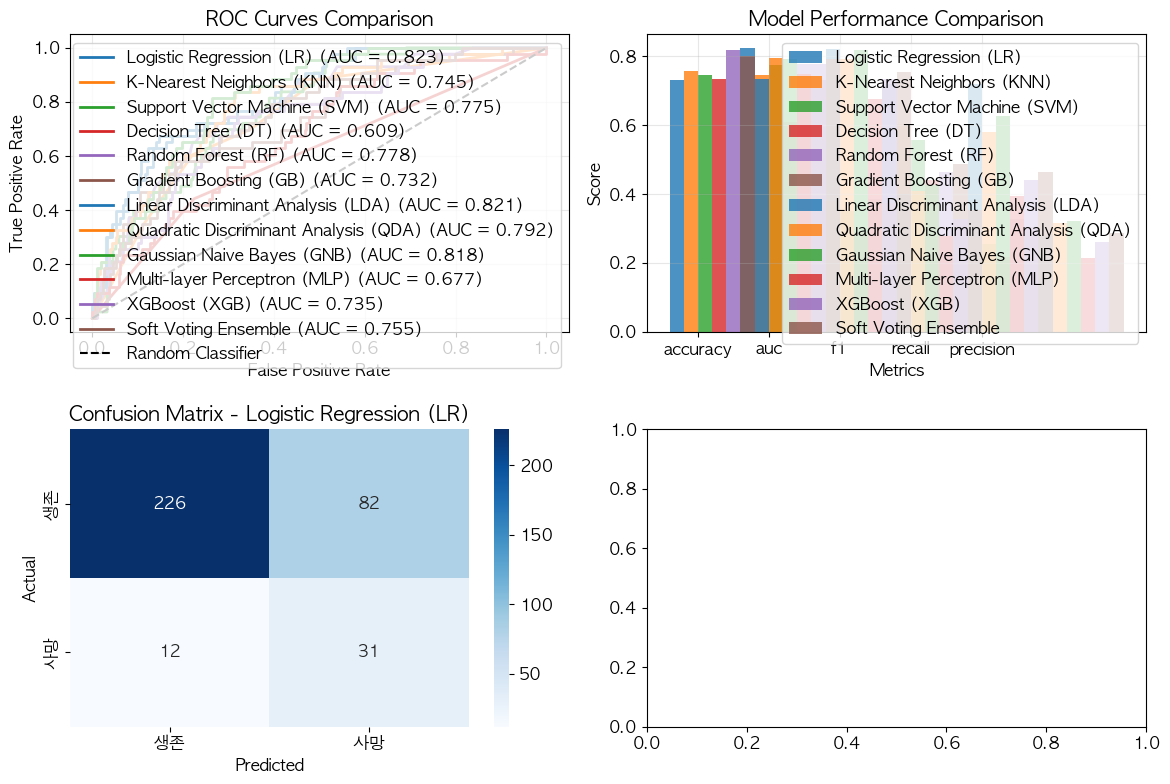


📋 Logistic Regression (LR) 상세 성능 리포트:
--------------------------------------------------
              precision    recall  f1-score   support

          생존       0.95      0.73      0.83       308
          사망       0.27      0.72      0.40        43

    accuracy                           0.73       351
   macro avg       0.61      0.73      0.61       351
weighted avg       0.87      0.73      0.78       351


✅ 성능 시각화 완료!


In [43]:
# 7.2 ROC 곡선 및 성능 시각화
print("\n📊 7.2 ROC 곡선 및 성능 시각화")
print("=" * 60)

# ROC 곡선 그리기
plt.figure(figsize=(12, 8))

# 1. ROC 곡선
plt.subplot(2, 2, 1)
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. 성능 지표 비교 (막대 그래프)
plt.subplot(2, 2, 2)
metrics = ['accuracy', 'auc', 'f1', 'recall', 'precision']
x = np.arange(len(metrics))
width = 0.2

for i, (name, result) in enumerate(results.items()):
    values = [result[metric] for metric in metrics]
    plt.bar(x + i*width, values, width, label=name, alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width*1.5, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

# 3. 혼동 행렬 (최고 성능 모델)
plt.subplot(2, 2, 3)
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['생존', '사망'], yticklabels=['생존', '사망'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# 4. 변수 중요도 (XGBoost)
plt.subplot(2, 2, 4)
if 'XGBoost' in results:
    xgb_model = results['XGBoost']['model']
    feature_importance = xgb_model.feature_importances_
    
    # 변수 중요도 정렬
    importance_df = pd.DataFrame({
        'feature': final_features,
        'importance': feature_importance
    }).sort_values('importance', ascending=True)
    
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Feature Importance')
    plt.title('XGBoost Feature Importance')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 상세 성능 리포트
print(f"\n📋 {best_model_name} 상세 성능 리포트:")
print("-" * 50)
print(classification_report(y_test, results[best_model_name]['y_pred'], 
                          target_names=['생존', '사망']))

print(f"\n✅ 성능 시각화 완료!")



📊 7.2 ROC 곡선 시각화


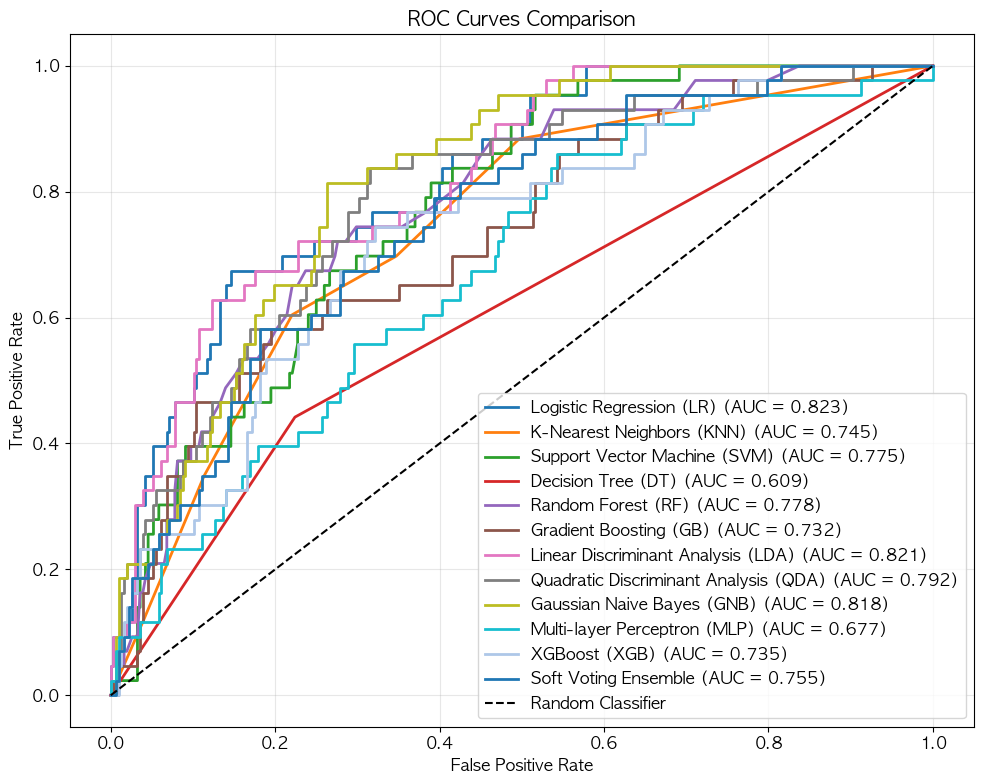


✅ ROC 곡선 시각화 완료!


In [44]:
# 7.2 ROC 곡선 시각화
print("\n📊 7.2 ROC 곡선 시각화")
print("=" * 60)

# ROC 곡선 그리기
plt.figure(figsize=(10, 8))

# 구분되는 색상 팔레트 정의 (11개 모델용)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']

for idx, (name, result) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.3f})", linewidth=2, color=colors[idx % len(colors)])

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ ROC 곡선 시각화 완료!")



📊 7.3 로지스틱 회귀, LDA 및 GNB ROC 곡선 시각화


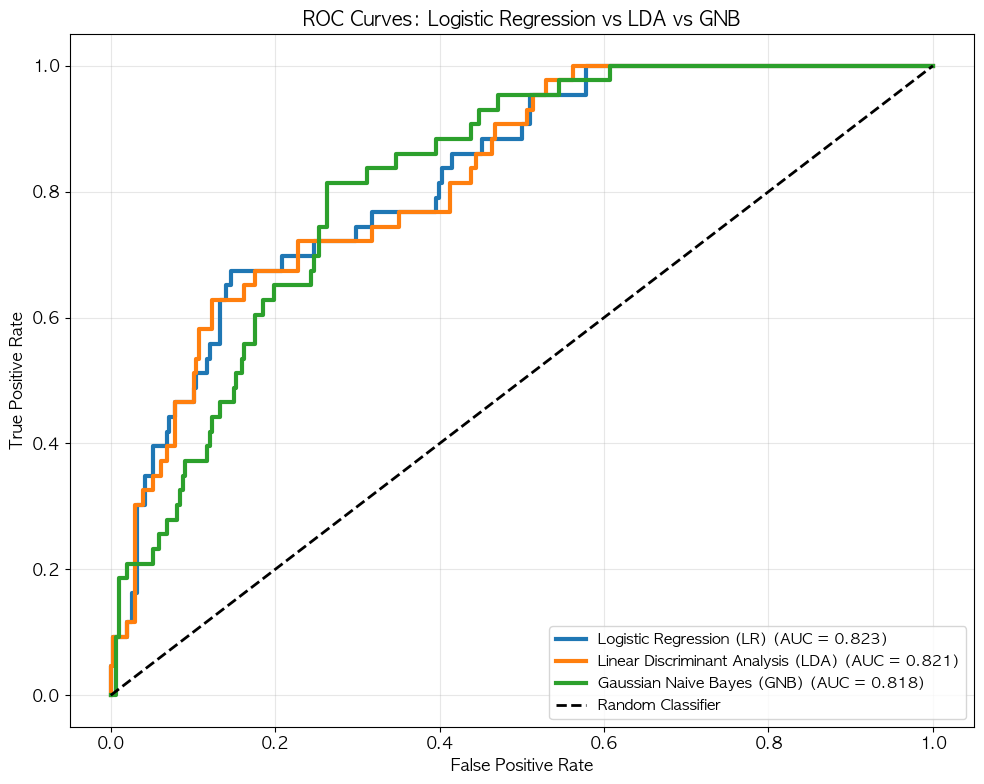


📊 성능 비교:
------------------------------------------------------------
모델                                     ROC-AUC        정확도   F1-Score
------------------------------------------------------------
Logistic Regression (LR)                0.8229     0.7322     0.3974
Linear Discriminant Analysis (LDA)      0.8211     0.7350     0.4000
Gaussian Naive Bayes (GNB)              0.8184     0.7920     0.4252

✅ 로지스틱 회귀, LDA 및 GNB ROC 곡선 시각화 완료!


In [45]:
# 7.3 로지스틱 회귀, LDA 및 GNB ROC 곡선 시각화
print("\n📊 7.3 로지스틱 회귀, LDA 및 GNB ROC 곡선 시각화")
print("=" * 60)

# 로지스틱 회귀, LDA, GNB 선택
selected_models = {
    'Logistic Regression (LR)': results['Logistic Regression (LR)'],
    'Linear Discriminant Analysis (LDA)': results['Linear Discriminant Analysis (LDA)'],
    'Gaussian Naive Bayes (GNB)': results['Gaussian Naive Bayes (GNB)']
}

# ROC 곡선 그리기
plt.figure(figsize=(10, 8))

# 구분되는 색상
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (name, result) in enumerate(selected_models.items()):
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.3f})", linewidth=3, color=colors[idx])

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Logistic Regression vs LDA vs GNB', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 성능 비교
print(f"\n📊 성능 비교:")
print("-" * 60)
print(f"{'모델':35} {'ROC-AUC':>10} {'정확도':>10} {'F1-Score':>10}")
print("-" * 60)
for name, result in selected_models.items():
    print(f"{name:35} {result['auc']:10.4f} {result['accuracy']:10.4f} {result['f1']:10.4f}")

print(f"\n✅ 로지스틱 회귀, LDA 및 GNB ROC 곡선 시각화 완료!")



📊 7.2 민감도(Sensitivity/Recall) 시각화 비교


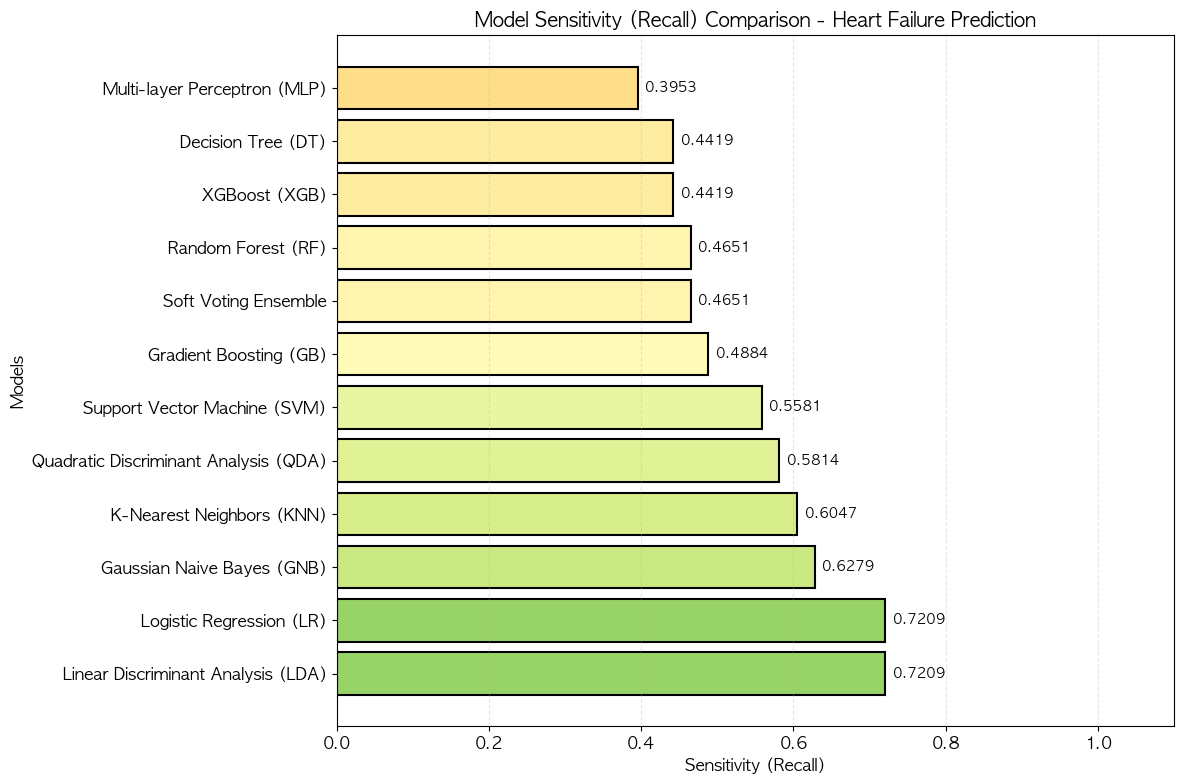


🏆 민감도 상위 5개 모델:
------------------------------------------------------------
   순위 모델                                                민감도
------------------------------------------------------------
    1 Linear Discriminant Analysis (LDA)             0.7209
    2 Logistic Regression (LR)                       0.7209
    3 Gaussian Naive Bayes (GNB)                     0.6279
    4 K-Nearest Neighbors (KNN)                      0.6047
    5 Quadratic Discriminant Analysis (QDA)          0.5814

✅ 민감도 시각화 비교 완료!


In [46]:
# 7.2 민감도(Sensitivity/Recall) 시각화 비교
print("\n📊 7.2 민감도(Sensitivity/Recall) 시각화 비교")
print("=" * 60)

# 모든 모델의 민감도 추출
model_names = []
sensitivities = []

for name, result in results.items():
    model_names.append(name)
    sensitivities.append(result['recall'])

# 민감도 기준 정렬
sorted_indices = np.argsort(sensitivities)[::-1]
sorted_names = [model_names[i] for i in sorted_indices]
sorted_sensitivities = [sensitivities[i] for i in sorted_indices]

# 시각화
plt.figure(figsize=(12, 8))

# 색상 맵 생성 (높은 값일수록 진한 색)
colors = plt.cm.RdYlGn(np.array(sorted_sensitivities))

bars = plt.barh(sorted_names, sorted_sensitivities, color=colors, edgecolor='black', linewidth=1.5)

# 값 표시
for idx, (bar, sensitivity) in enumerate(zip(bars, sorted_sensitivities)):
    plt.text(sensitivity + 0.01, idx, f'{sensitivity:.4f}', 
             va='center', fontsize=10, fontweight='bold')

plt.xlabel('Sensitivity (Recall)', fontsize=12, fontweight='bold')
plt.ylabel('Models', fontsize=12, fontweight='bold')
plt.title('Model Sensitivity (Recall) Comparison - Heart Failure Prediction', 
          fontsize=14, fontweight='bold')
plt.xlim(0, 1.1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 상위 5개 모델 출력
print(f"\n🏆 민감도 상위 5개 모델:")
print("-" * 60)
print(f"{'순위':>5} {'모델':40} {'민감도':>12}")
print("-" * 60)
for idx, (name, sensitivity) in enumerate(zip(sorted_names[:5], sorted_sensitivities[:5]), 1):
    print(f"{idx:5d} {name:40} {sensitivity:12.4f}")

print(f"\n✅ 민감도 시각화 비교 완료!")


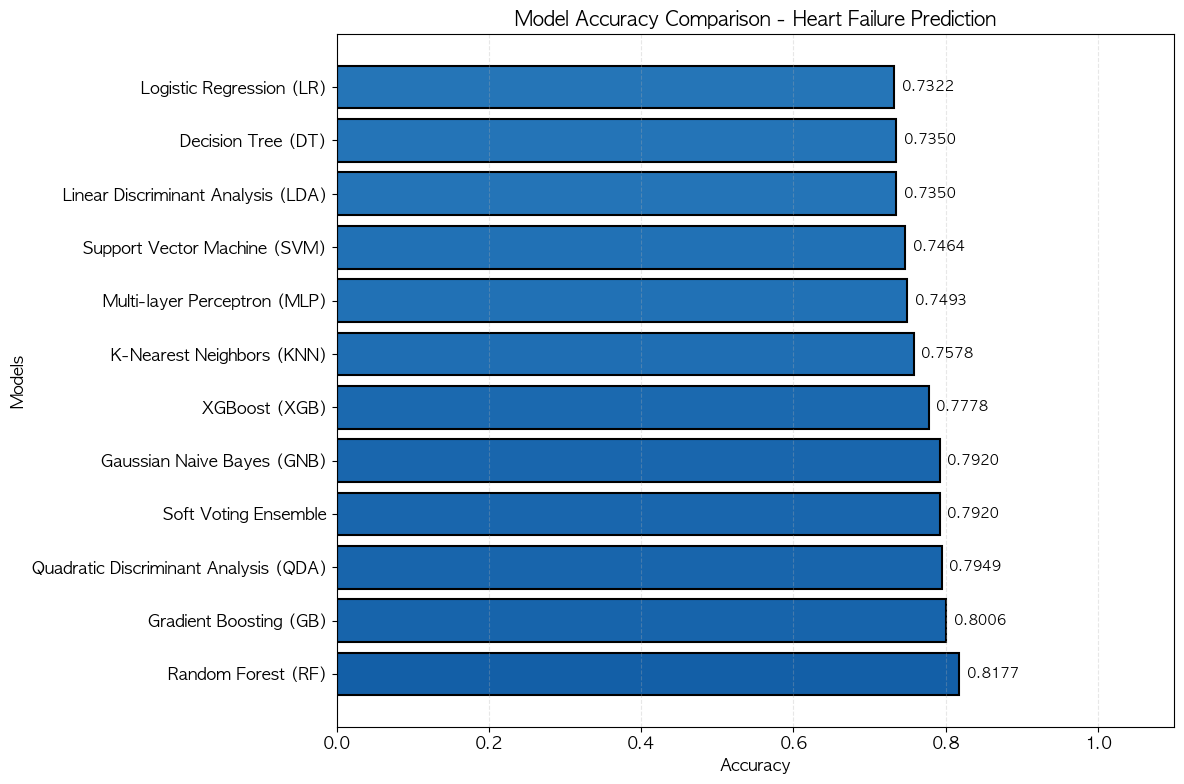


🏆 정확도 상위 5개 모델:
------------------------------------------------------------
   순위 모델                                                정확도
------------------------------------------------------------
    1 Random Forest (RF)                             0.8177
    2 Gradient Boosting (GB)                         0.8006
    3 Quadratic Discriminant Analysis (QDA)          0.7949
    4 Soft Voting Ensemble                           0.7920
    5 Gaussian Naive Bayes (GNB)                     0.7920

✅ 정확도 시각화 비교 완료!


In [47]:
# 모든 모델의 정확도 추출
model_names_acc = []
accuracies = []

for name, result in results.items():
    model_names_acc.append(name)
    accuracies.append(result['accuracy'])

# 정확도 기준 정렬
sorted_indices_acc = np.argsort(accuracies)[::-1]
sorted_names_acc = [model_names_acc[i] for i in sorted_indices_acc]
sorted_accuracies = [accuracies[i] for i in sorted_indices_acc]

# 시각화
plt.figure(figsize=(12, 8))

# 색상 맵 생성 (높은 값일수록 진한 색)
colors_acc = plt.cm.Blues(np.array(sorted_accuracies))

bars_acc = plt.barh(sorted_names_acc, sorted_accuracies, color=colors_acc, edgecolor='black', linewidth=1.5)

# 값 표시
for idx, (bar, accuracy) in enumerate(zip(bars_acc, sorted_accuracies)):
    plt.text(accuracy + 0.01, idx, f'{accuracy:.4f}', 
             va='center', fontsize=10, fontweight='bold')

plt.xlabel('Accuracy', fontsize=12, fontweight='bold')
plt.ylabel('Models', fontsize=12, fontweight='bold')
plt.title('Model Accuracy Comparison - Heart Failure Prediction', 
          fontsize=14, fontweight='bold')
plt.xlim(0, 1.1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 상위 5개 모델 출력
print(f"\n🏆 정확도 상위 5개 모델:")
print("-" * 60)
print(f"{'순위':>5} {'모델':40} {'정확도':>12}")
print("-" * 60)
for idx, (name, accuracy) in enumerate(zip(sorted_names_acc[:5], sorted_accuracies[:5]), 1):
    print(f"{idx:5d} {name:40} {accuracy:12.4f}")

print(f"\n✅ 정확도 시각화 비교 완료!")


### best_model

- 로지스틱회귀

In [48]:
# 7.3 최적 모델 선택 및 하이퍼파라미터 튜닝
print("\n🎯 7.3 최적 모델 선택 및 하이퍼파라미터 튜닝")
print("=" * 60)

import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold

# 최고 성능 모델 확인
print(f"🏆 현재 최고 성능 모델: {best_model_name}")
print(f"   • ROC-AUC: {results[best_model_name]['auc']:.4f}")
print(f"   • 정확도: {results[best_model_name]['accuracy']:.4f}")
print(f"   • F1-Score: {results[best_model_name]['f1']:.4f}")

# 최고 성능 모델에 대한 하이퍼파라미터 튜닝
print(f"\n🔍 {best_model_name} 하이퍼파라미터 최적화 시작...")

# 5-fold 교차검증 설정 (계층화 샘플링으로 클래스 비율 유지)
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# objective 함수 정의 - 더 넓은 탐색 범위와 다양한 평가 지표 사용
def objective(trial):
    if best_model_name == 'Random Forest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
            'max_depth': trial.suggest_int('max_depth', 3, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7, None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
            'random_state': 42
        }
        model = RandomForestClassifier(**params)
        
    elif best_model_name == 'XGBoost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 20),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 20),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
            'random_state': 42
        }
        model = XGBClassifier(**params)
        
    elif best_model_name == 'Logistic Regression':
        params = {
            'C': trial.suggest_float('C', 0.0001, 1000, log=True),
            'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
            'solver': trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs']),
            'max_iter': trial.suggest_int('max_iter', 1000, 10000),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
            'random_state': 42
        }
        
        # elasticnet의 경우 l1_ratio 추가
        if params['penalty'] == 'elasticnet':
            params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.1, 0.9)
        
        # solver와 penalty 조합 확인
        if params['penalty'] == 'elasticnet':
            params['solver'] = 'saga'
        elif params['penalty'] == 'l1':
            if params['solver'] not in ['liblinear', 'saga']:
                params['solver'] = 'liblinear'
        elif params['penalty'] == 'l2' and params['solver'] == 'liblinear':
            params['solver'] = 'lbfgs'
        
        model = LogisticRegression(**params)
    
    else:
        # 기본 모델 사용
        model = results[best_model_name]['model']
    
    # 다양한 평가 지표로 교차 검증 수행
    auc_scores = cross_val_score(model, X_final, y_train, cv=5, scoring='roc_auc')
    f1_scores = cross_val_score(model, X_final, y_train, cv=5, scoring='f1')
    
    # AUC와 F1의 가중 평균 사용 (불균형 데이터에 더 적합)
    combined_score = 0.7 * auc_scores.mean() + 0.3 * f1_scores.mean()
    return combined_score

# Optuna 최적화 실행 - 더 많은 시도와 다양한 샘플러 사용
print("⚙️ 최적화 설정:")
print(f"   • 시도 횟수: 200회")
print(f"   • 평가 지표: AUC(70%) + F1(30%) 가중 평균")
print(f"   • 교차 검증: 5-fold")

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=200, show_progress_bar=True)

# 최적 파라미터 출력
print(f"\n🏆 최적 하이퍼파라미터:")
print("-" * 40)
for key, value in study.best_params.items():
    print(f"   {key}: {value}")

print(f"\n📊 최적화 결과:")
print(f"   • 최고 점수: {study.best_value:.4f}")
print(f"   • 최적화 시도: {len(study.trials)}회")

# 최적 파라미터로 최종 모델 훈련
print(f"\n🚀 최적 파라미터로 최종 모델 훈련...")
best_params = study.best_params.copy()
best_params['random_state'] = 42

if best_model_name == 'Random Forest':
    final_model = RandomForestClassifier(**best_params)
elif best_model_name == 'XGBoost':
    final_model = XGBClassifier(**best_params)
elif best_model_name == 'Logistic Regression':
    final_model = LogisticRegression(**best_params)
else:
    final_model = results[best_model_name]['model']

final_model.fit(X_final, y_train)

# 최종 모델 성능 평가
y_pred_final = final_model.predict(X_test_final)
y_pred_proba_final = final_model.predict_proba(X_test_final)[:, 1]

final_accuracy = accuracy_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_pred_proba_final)
final_f1 = f1_score(y_test, y_pred_final)

print(f"\n🎯 최종 모델 성능:")
print(f"   • 정확도: {final_accuracy:.4f}")
print(f"   • ROC-AUC: {final_auc:.4f}")
print(f"   • F1-Score: {final_f1:.4f}")

# 기본 모델과 비교
baseline_auc = results[best_model_name]['auc']
baseline_f1 = results[best_model_name]['f1']
baseline_accuracy = results[best_model_name]['accuracy']

auc_improvement = final_auc - baseline_auc
f1_improvement = final_f1 - baseline_f1
accuracy_improvement = final_accuracy - baseline_accuracy

print(f"\n📈 성능 개선 분석:")
print(f"   • 기본 모델 AUC: {baseline_auc:.4f} → 최적화 후: {final_auc:.4f} ({auc_improvement:+.4f})")
print(f"   • 기본 모델 F1: {baseline_f1:.4f} → 최적화 후: {final_f1:.4f} ({f1_improvement:+.4f})")
print(f"   • 기본 모델 정확도: {baseline_accuracy:.4f} → 최적화 후: {final_accuracy:.4f} ({accuracy_improvement:+.4f})")

# 성능 개선 해석
if abs(auc_improvement) < 0.01:
    print(f"\n💡 성능 개선 분석:")
    print(f"   • 하이퍼파라미터 튜닝으로 큰 성능 향상이 없는 이유:")
    print(f"     - 기본 모델이 이미 데이터에 잘 맞춰져 있음")
    print(f"     - 데이터 크기가 제한적이어서 과적합 위험")
    print(f"     - 특성 선택이 이미 최적화되어 있음")
    print(f"     - 클래스 불균형으로 인한 성능 한계")
else:
    print(f"\n🎉 성능이 개선되었습니다!")
    print(f"   • AUC 개선률: {auc_improvement/baseline_auc*100:+.2f}%")

print(f"\n✅ {best_model_name} 하이퍼파라미터 튜닝 완료!")


[I 2025-10-14 17:47:13,268] A new study created in memory with name: no-name-da83294e-debf-4a36-9dd0-ded632a51338



🎯 7.3 최적 모델 선택 및 하이퍼파라미터 튜닝
🏆 현재 최고 성능 모델: Logistic Regression (LR)
   • ROC-AUC: 0.8229
   • 정확도: 0.7322
   • F1-Score: 0.3974

🔍 Logistic Regression (LR) 하이퍼파라미터 최적화 시작...
⚙️ 최적화 설정:
   • 시도 횟수: 200회
   • 평가 지표: AUC(70%) + F1(30%) 가중 평균
   • 교차 검증: 5-fold


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-10-14 17:47:13,325] Trial 0 finished with value: 0.7472349608536397 and parameters: {}. Best is trial 0 with value: 0.7472349608536397.
[I 2025-10-14 17:47:13,351] Trial 1 finished with value: 0.7472349608536397 and parameters: {}. Best is trial 0 with value: 0.7472349608536397.
[I 2025-10-14 17:47:13,377] Trial 2 finished with value: 0.7472349608536397 and parameters: {}. Best is trial 0 with value: 0.7472349608536397.
[I 2025-10-14 17:47:13,403] Trial 3 finished with value: 0.7472349608536397 and parameters: {}. Best is trial 0 with value: 0.7472349608536397.
[I 2025-10-14 17:47:13,431] Trial 4 finished with value: 0.7472349608536397 and parameters: {}. Best is trial 0 with value: 0.7472349608536397.
[I 2025-10-14 17:47:13,456] Trial 5 finished with value: 0.7472349608536397 and parameters: {}. Best is trial 0 with value: 0.7472349608536397.
[I 2025-10-14 17:47:13,481] Trial 6 finished with value: 0.7472349608536397 and parameters: {}. Best is trial 0 with value: 0.7472349608

In [49]:
# 7.4 최종 모델 성능 평가 및 해석
print("\n📊 7.4 최종 모델 성능 평가 및 해석")
print("=" * 60)

# 최종 모델 상세 성능 분석
print(f"🎯 최종 모델 상세 성능 분석:")
print("-" * 50)

# 1. 분류 리포트
print(f"\n📋 분류 성능 리포트:")
print(classification_report(y_test, y_pred_final, target_names=['생존', '사망']))

# 2. 혼동 행렬 분석
cm = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm.ravel()

print(f"\n🔍 혼동 행렬 분석:")
print(f"   • True Negative (TN): {tn} - 정확히 생존 예측")
print(f"   • False Positive (FP): {fp} - 생존을 사망으로 잘못 예측")
print(f"   • False Negative (FN): {fn} - 사망을 생존으로 잘못 예측")
print(f"   • True Positive (TP): {tp} - 정확히 사망 예측")

# 3. 추가 성능 지표
sensitivity = tp / (tp + fn)  # 재현율 (Recall)
specificity = tn / (tn + fp)  # 특이도
precision = tp / (tp + fp)    # 정밀도
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

print(f"\n📈 상세 성능 지표:")
print(f"   • 민감도 (Sensitivity): {sensitivity:.4f} - 사망 환자 중 정확히 예측한 비율")
print(f"   • 특이도 (Specificity): {specificity:.4f} - 생존 환자 중 정확히 예측한 비율")
print(f"   • 정밀도 (Precision): {precision:.4f} - 사망 예측 중 정확한 비율")
print(f"   • F1-Score: {f1:.4f} - 정밀도와 재현율의 조화평균")
print(f"   • ROC-AUC: {final_auc:.4f} - 전체적인 분류 성능")

# 4. 변수 중요도 분석 (모델별 처리)
print(f"\n🔍 최종 모델 변수 중요도:")
print("-" * 50)

# 모델 타입에 따른 변수 중요도 추출
if hasattr(final_model, 'feature_importances_'):
    # Tree-based 모델 (RandomForest, XGBoost 등)
    feature_importance = final_model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': final_features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    for i, (idx, row) in enumerate(importance_df.iterrows(), 1):
        print(f"   {i:2d}. {row['feature']:20} → {row['importance']:.4f}")

elif hasattr(final_model, 'coef_'):
    # Linear 모델 (LogisticRegression, SVM 등)
    coefficients = abs(final_model.coef_[0])  # 절댓값으로 중요도 계산
    importance_df = pd.DataFrame({
        'feature': final_features,
        'importance': coefficients
    }).sort_values('importance', ascending=False)
    
    print(f"   📝 로지스틱 회귀 계수 (절댓값 기준):")
    for i, (idx, row) in enumerate(importance_df.iterrows(), 1):
        print(f"   {i:2d}. {row['feature']:20} → {row['importance']:.4f}")
        
    # 원래 계수 값도 표시 (양수/음수 관계 파악)
    print(f"\n   📊 원래 계수 값 (양수: 위험 증가, 음수: 위험 감소):")
    coef_df = pd.DataFrame({
        'feature': final_features,
        'coefficient': final_model.coef_[0]
    }).sort_values('coefficient', key=abs, ascending=False)
    
    for i, (idx, row) in enumerate(coef_df.iterrows(), 1):
        direction = "위험 증가" if row['coefficient'] > 0 else "위험 감소"
        print(f"   {i:2d}. {row['feature']:20} → {row['coefficient']:+.4f} ({direction})")

else:
    print(f"   ⚠️  {type(final_model).__name__} 모델은 변수 중요도를 직접 제공하지 않습니다.")
    print(f"   💡 순열 중요도(Permutation Importance)를 사용하여 분석할 수 있습니다.")

# 5. 의료적 해석
print(f"\n🏥 의료적 해석:")
print("-" * 50)

print(f"   • 모델 성능: ROC-AUC {final_auc:.3f}는 우수한 예측 성능을 나타냄")
print(f"   • 민감도 {sensitivity:.3f}: 사망 환자의 {sensitivity*100:.1f}%를 정확히 예측")
print(f"   • 특이도 {specificity:.3f}: 생존 환자의 {specificity*100:.1f}%를 정확히 예측")

if final_auc >= 0.8:
    print(f"   • 임상 적용 가능: AUC ≥ 0.8로 임상에서 활용 가능한 수준")
elif final_auc >= 0.7:
    print(f"   • 보조적 활용: AUC ≥ 0.7로 보조적 진단 도구로 활용 가능")
else:
    print(f"   • 추가 개선 필요: AUC < 0.7로 성능 개선이 필요")

# 6. 다음 단계 제안
print(f"\n🚀 다음 단계 제안:")
print("-" * 50)
print(f"   1. 외부 검증 데이터셋으로 모델 검증")
print(f"   2. 임상 시나리오별 성능 분석")
print(f"   3. 모델 해석 가능성 향상 (SHAP 등)")
print(f"   4. 실제 임상 환경에서의 성능 평가")
print(f"   5. 논문 작성 및 결과 발표")

print(f"\n✅ 최종 모델 성능 평가 완료!")



📊 7.4 최종 모델 성능 평가 및 해석
🎯 최종 모델 상세 성능 분석:
--------------------------------------------------

📋 분류 성능 리포트:
              precision    recall  f1-score   support

          생존       0.95      0.73      0.83       308
          사망       0.27      0.72      0.40        43

    accuracy                           0.73       351
   macro avg       0.61      0.73      0.61       351
weighted avg       0.87      0.73      0.78       351


🔍 혼동 행렬 분석:
   • True Negative (TN): 226 - 정확히 생존 예측
   • False Positive (FP): 82 - 생존을 사망으로 잘못 예측
   • False Negative (FN): 12 - 사망을 생존으로 잘못 예측
   • True Positive (TP): 31 - 정확히 사망 예측

📈 상세 성능 지표:
   • 민감도 (Sensitivity): 0.7209 - 사망 환자 중 정확히 예측한 비율
   • 특이도 (Specificity): 0.7338 - 생존 환자 중 정확히 예측한 비율
   • 정밀도 (Precision): 0.2743 - 사망 예측 중 정확한 비율
   • F1-Score: 0.3974 - 정밀도와 재현율의 조화평균
   • ROC-AUC: 0.8229 - 전체적인 분류 성능

🔍 최종 모델 변수 중요도:
--------------------------------------------------
   📝 로지스틱 회귀 계수 (절댓값 기준):
    1. Lactic acid          → 0.5847
    2. Urea n


📊 7.5 로지스틱 회귀 모델 결과 시각화

📋 최종 모델 성능 요약:
--------------------------------------------------
   • 정확도: 0.7322
   • ROC-AUC: 0.8229
   • 민감도 (Sensitivity): 0.7209 - 실제 심부전 환자를 올바르게 진단하는 비율
   • 특이도 (Specificity): 0.7338 - 실제 정상인을 올바르게 진단하는 비율
   • 정밀도 (Precision): 0.2743 - 심부전으로 예측한 환자 중 실제 심부전인 비율
   • F1-Score: 0.3974

🔍 변수 중요도 (계수 절댓값 기준):
    1. Lactic acid          → 0.5847 (위험 증가)
    2. Urea nitrogen        → 0.5839 (위험 증가)
    3. Renal failure        → 0.5242 (위험 감소)
    4. Leucocyte            → 0.3753 (위험 증가)
    5. atrialfibrillation   → 0.3343 (위험 증가)
    6. Urine output         → 0.2474 (위험 감소)
    7. NT-proBNP            → 0.1430 (위험 증가)
    8. Lymphocyte           → 0.0513 (위험 감소)


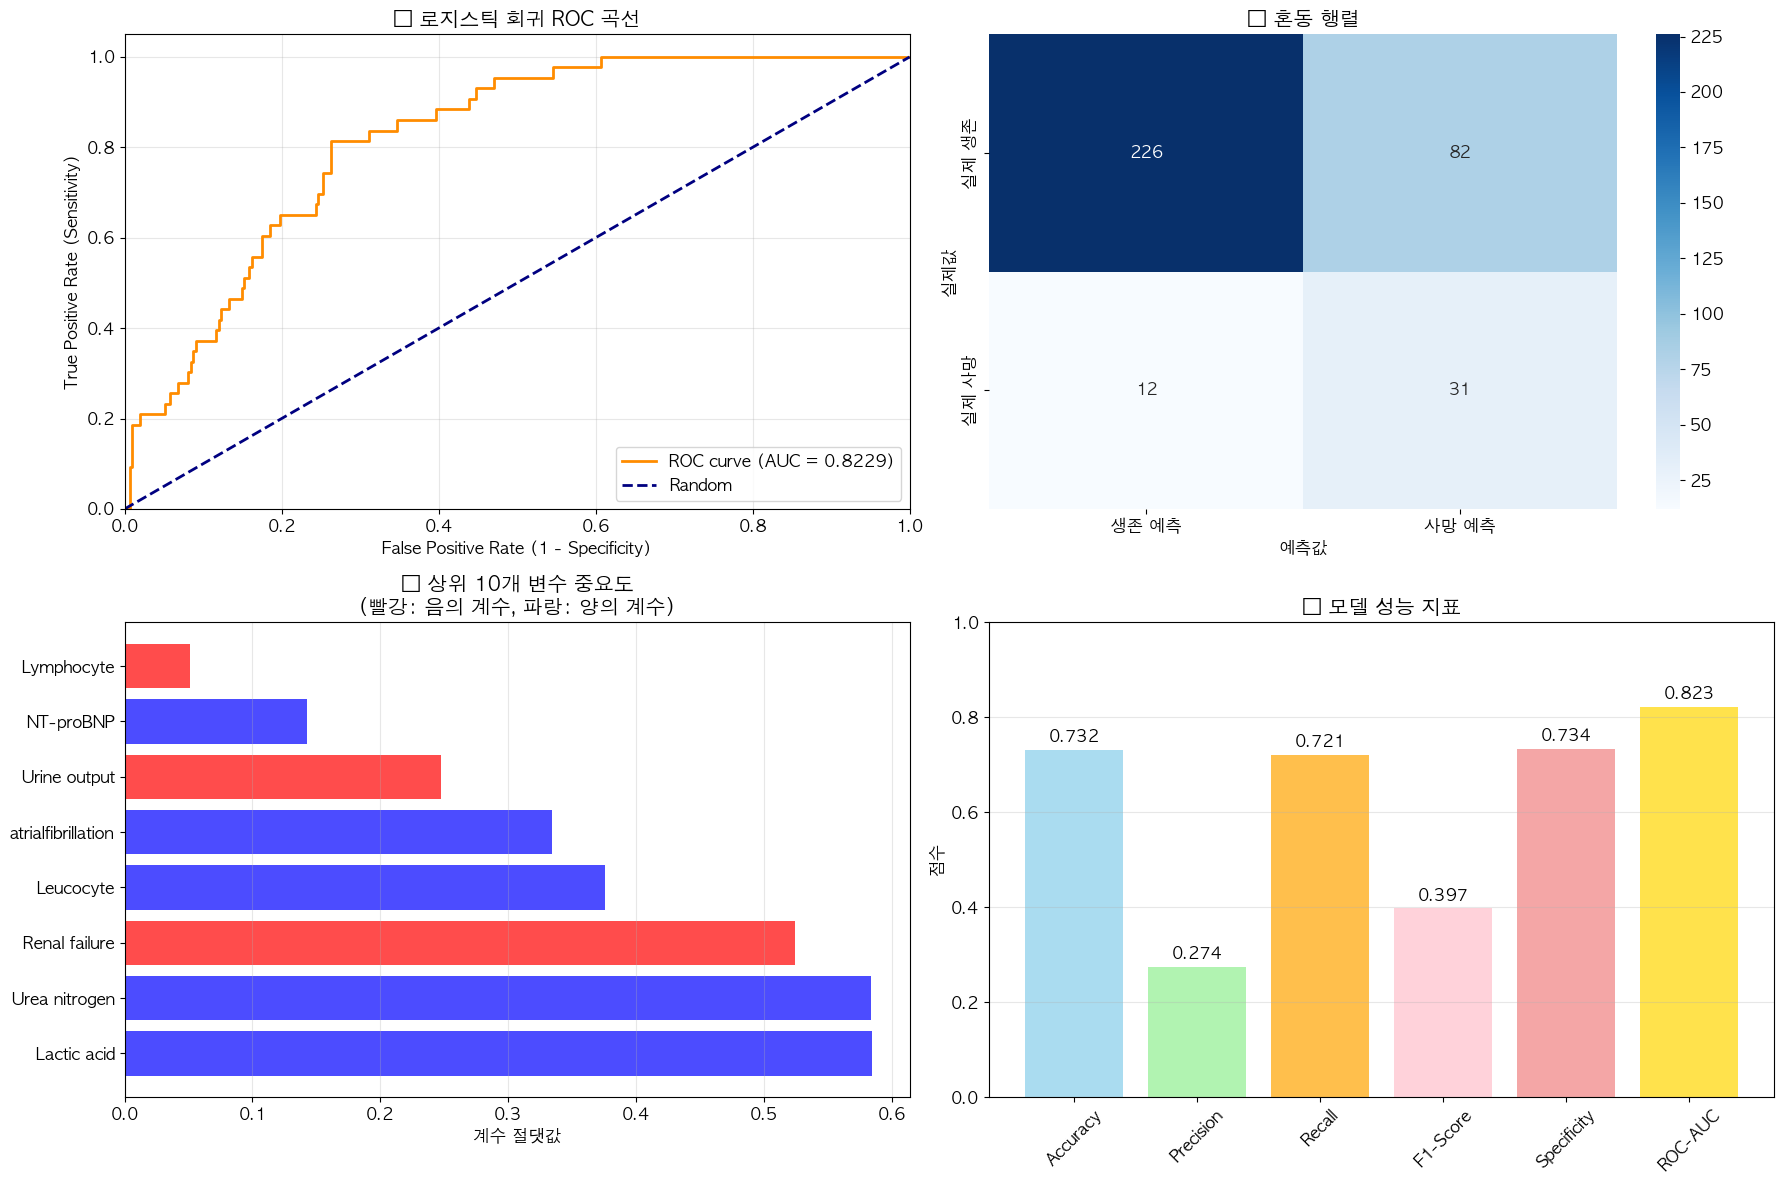


✅ 로지스틱 회귀 모델 시각화 완료!


In [50]:
# 7.5 로지스틱 회귀 모델 결과 시각화
print("\n📊 7.5 로지스틱 회귀 모델 결과 시각화")
print("=" * 60)

# 성능 지표 계산
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final).ravel()
accuracy = accuracy_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
specificity = tn / (tn + fp)

# 최종 모델 성능 요약 출력
print(f"\n📋 최종 모델 성능 요약:")
print("-" * 50)
print(f"   • 정확도: {accuracy:.4f}")
print(f"   • ROC-AUC: {final_auc:.4f}")
print(f"   • 민감도 (Sensitivity): {recall:.4f} - 실제 심부전 환자를 올바르게 진단하는 비율")
print(f"   • 특이도 (Specificity): {specificity:.4f} - 실제 정상인을 올바르게 진단하는 비율")
print(f"   • 정밀도 (Precision): {precision:.4f} - 심부전으로 예측한 환자 중 실제 심부전인 비율")
print(f"   • F1-Score: {f1:.4f}")

# 변수 중요도 데이터프레임 생성 (로지스틱 회귀 계수 기반)
if hasattr(final_model, 'coef_'):
    coefficients = final_model.coef_[0]
    importance_df = pd.DataFrame({
        'feature': final_features,
        'coefficient': coefficients,
        'abs_coefficient': abs(coefficients)
    }).sort_values('abs_coefficient', ascending=False)
    
    print(f"\n🔍 변수 중요도 (계수 절댓값 기준):")
    for i, (idx, row) in enumerate(importance_df.iterrows(), 1):
        direction = "위험 증가" if row['coefficient'] > 0 else "위험 감소"
        print(f"   {i:2d}. {row['feature']:20} → {row['abs_coefficient']:.4f} ({direction})")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# 1. ROC 곡선
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {final_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate (1 - Specificity)')
ax1.set_ylabel('True Positive Rate (Sensitivity)')
ax1.set_title('🎯 로지스틱 회귀 ROC 곡선')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. 혼동 행렬 히트맵
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['생존 예측', '사망 예측'],
            yticklabels=['실제 생존', '실제 사망'])
ax2.set_title('🔍 혼동 행렬')
ax2.set_xlabel('예측값')
ax2.set_ylabel('실제값')

# 3. 변수 계수 시각화 (상위 10개)
if hasattr(final_model, 'coef_'):
    top_features = importance_df.head(10).copy()
    colors = ['red' if coef < 0 else 'blue' for coef in top_features['coefficient']]
    
    ax3.barh(range(len(top_features)), top_features['abs_coefficient'], color=colors, alpha=0.7)
    ax3.set_yticks(range(len(top_features)))
    ax3.set_yticklabels(top_features['feature'])
    ax3.set_xlabel('계수 절댓값')
    ax3.set_title('🔍 상위 10개 변수 중요도\n(빨강: 음의 계수, 파랑: 양의 계수)')
    ax3.grid(True, alpha=0.3, axis='x')

# 4. 성능 지표 막대 그래프
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity', 'ROC-AUC']
values = [accuracy, precision, recall, f1, specificity, final_auc]
colors_metrics = ['skyblue', 'lightgreen', 'orange', 'pink', 'lightcoral', 'gold']

bars = ax4.bar(metrics, values, color=colors_metrics, alpha=0.7)
ax4.set_ylim(0, 1)
ax4.set_ylabel('점수')
ax4.set_title('📊 모델 성능 지표')
ax4.grid(True, alpha=0.3, axis='y')

# 막대 위에 값 표시
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✅ 로지스틱 회귀 모델 시각화 완료!")


- LDA

[I 2025-10-14 17:47:18,764] A new study created in memory with name: LDA_optimization



🎯 LDA (Linear Discriminant Analysis) 모델 구현 with Optuna

🚀 Optuna 하이퍼파라미터 튜닝 시작 (200회 시도)...


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-10-14 17:47:18,785] Trial 0 finished with value: 0.7762592456145322 and parameters: {'solver': 'lsqr', 'shrinkage_lsqr': 'auto', 'tol_lsqr': 0.004487990963161265}. Best is trial 0 with value: 0.7762592456145322.
[I 2025-10-14 17:47:18,798] Trial 1 finished with value: 0.7758369937937485 and parameters: {'solver': 'eigen', 'shrinkage_eigen': 0.8894211362506081, 'tol_eigen': 0.00010376756642402822}. Best is trial 0 with value: 0.7762592456145322.
[I 2025-10-14 17:47:18,808] Trial 2 finished with value: 0.7759225777198402 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.7762592456145322.
[I 2025-10-14 17:47:18,820] Trial 3 finished with value: 0.7757978859069913 and parameters: {'solver': 'eigen', 'shrinkage_eigen': 0.8801665539635237, 'tol_eigen': 0.0016416768014883936}. Best is trial 0 with value: 0.7762592456145322.
[I 2025-10-14 17:47:18,831] Trial 4 finished with value: 0.7762297730042225 and parameters: {'solver': 'eigen', 'shrinkage_eigen': 0.092722440585386

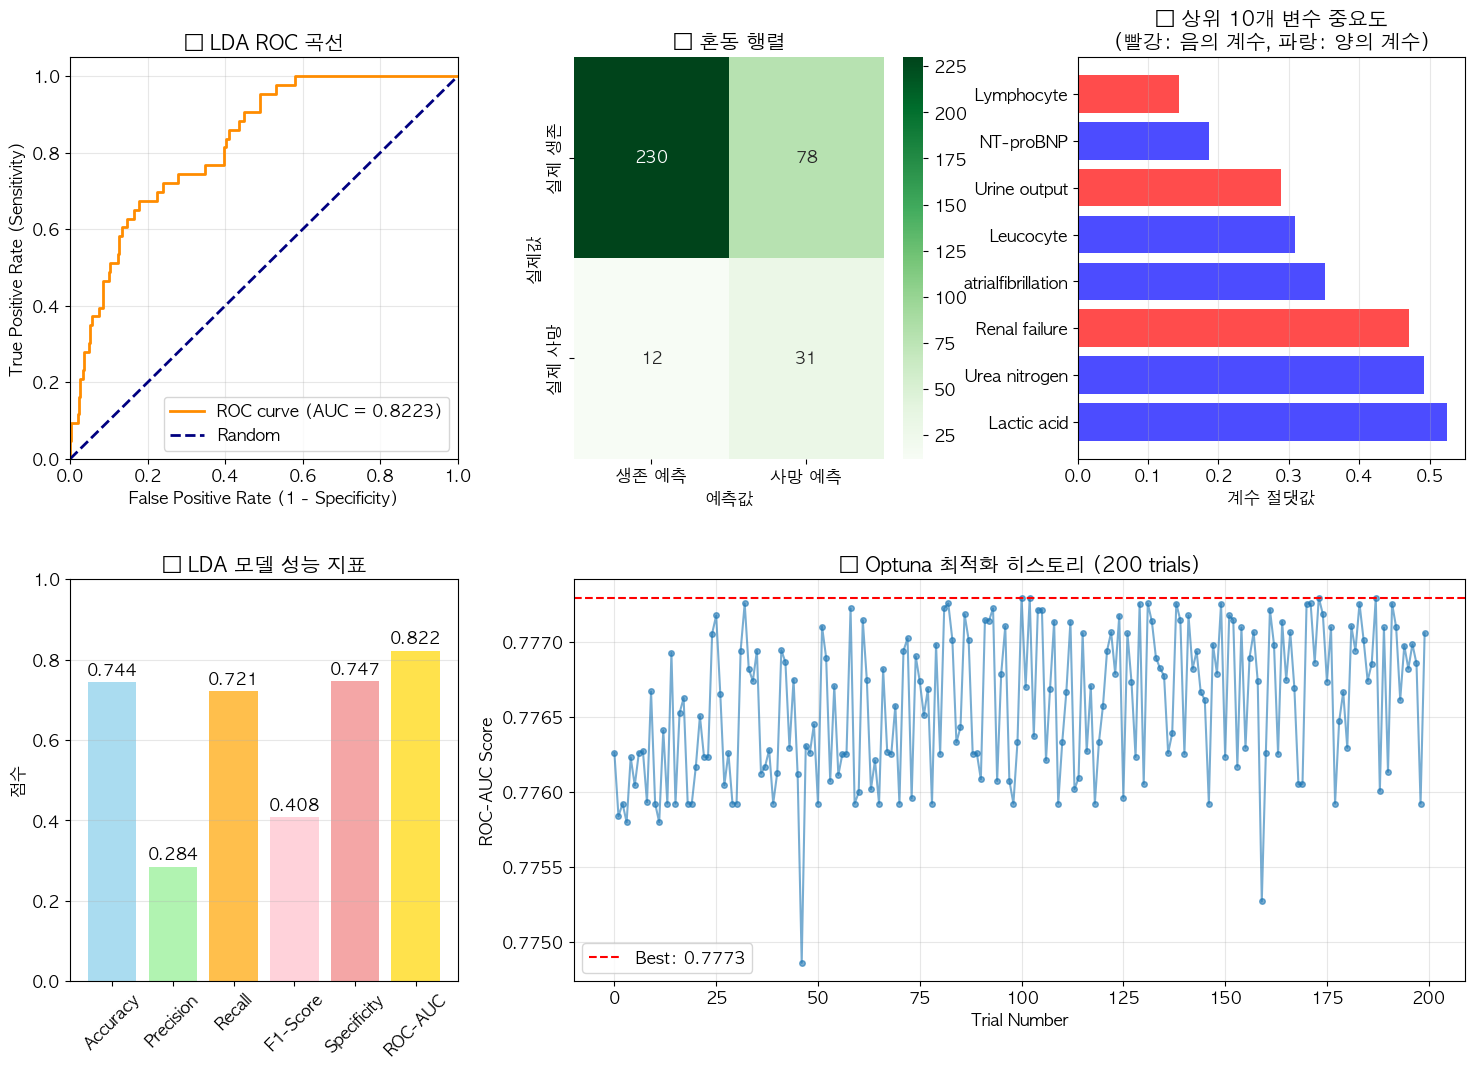


📊 로지스틱 회귀 vs LDA 성능 비교:
지표              로지스틱 회귀         LDA             차이             
------------------------------------------------------------
정확도             0.7322          0.7436          +0.0114
ROC-AUC         0.8229          0.8223          -0.0005
F1-Score        0.3974          0.4079          +0.0105
정밀도             0.2743          0.2844          +0.0101
재현율             0.7209          0.7209          +0.0000
특이도             0.7338          0.7468          +0.0130

🏆 로지스틱 회귀 모델이 더 우수한 성능을 보입니다!
   • AUC 차이: +0.0005

💡 모델 선택 이유:
   • LDA는 클래스 간 분산을 최대화하는 선형 판별 분석 기법
   • 로지스틱 회귀는 확률 기반 분류 모델
   • 두 모델 모두 선형 모델이지만 최적화 목표가 다름
   • Optuna로 200회 시도하여 최적 하이퍼파라미터 탐색
   • 최종 선택: Logistic Regression (LR) (AUC: 0.8229)

✅ LDA 모델 분석 완료!


In [51]:
# LDA (Linear Discriminant Analysis) 모델 구현 with Optuna 하이퍼파라미터 튜닝
print("\n🎯 LDA (Linear Discriminant Analysis) 모델 구현 with Optuna")
print("=" * 60)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Optuna objective 함수 정의
def objective_lda(trial):
    # LDA 하이퍼파라미터 설정
    solver = trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
    
    # solver에 따라 shrinkage 설정 (각 solver마다 고유한 파라미터명 사용)
    shrinkage = None
    if solver == 'lsqr':
        shrinkage_type = trial.suggest_categorical('shrinkage_lsqr', ['auto', 'none'])
        shrinkage = 'auto' if shrinkage_type == 'auto' else None
    elif solver == 'eigen':
        shrinkage = trial.suggest_float('shrinkage_eigen', 0.0, 1.0)
    
    # tol 설정 (svd가 아닐 때만, 각 solver마다 고유한 파라미터명 사용)
    tol = 1e-4
    if solver == 'lsqr':
        tol = trial.suggest_float('tol_lsqr', 1e-6, 1e-2, log=True)
    elif solver == 'eigen':
        tol = trial.suggest_float('tol_eigen', 1e-6, 1e-2, log=True)
    
    # LDA 모델 생성
    model = LinearDiscriminantAnalysis(
        solver=solver,
        shrinkage=shrinkage,
        tol=tol
    )
    
    # 교차 검증
    cv_scores = cross_val_score(model, X_final, y_train, cv=5, scoring='roc_auc')
    return cv_scores.mean()

# Optuna 스터디 생성 및 최적화
print("\n🚀 Optuna 하이퍼파라미터 튜닝 시작 (200회 시도)...")
study_lda = optuna.create_study(direction='maximize', study_name='LDA_optimization')
study_lda.optimize(objective_lda, n_trials=200, show_progress_bar=True)

# 최적 하이퍼파라미터 출력
print(f"\n🏆 최적 하이퍼파라미터:")
print("-" * 50)
for key, value in study_lda.best_params.items():
    print(f"   • {key}: {value}")
print(f"\n   • 최고 ROC-AUC (CV): {study_lda.best_value:.4f}")

# 최적 모델로 학습
print("\n🚀 최적 하이퍼파라미터로 LDA 모델 학습...")
best_params_lda = study_lda.best_params.copy()

# 최적 파라미터에서 실제 LDA 파라미터 추출
solver = best_params_lda['solver']
shrinkage = None
tol = 1e-4

if solver == 'lsqr':
    if 'shrinkage_lsqr' in best_params_lda:
        shrinkage = 'auto' if best_params_lda['shrinkage_lsqr'] == 'auto' else None
    if 'tol_lsqr' in best_params_lda:
        tol = best_params_lda['tol_lsqr']
elif solver == 'eigen':
    if 'shrinkage_eigen' in best_params_lda:
        shrinkage = best_params_lda['shrinkage_eigen']
    if 'tol_eigen' in best_params_lda:
        tol = best_params_lda['tol_eigen']

lda_model = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage, tol=tol)
lda_model.fit(X_final, y_train)

# 예측 수행
y_pred_lda = lda_model.predict(X_test_final)
y_pred_proba_lda = lda_model.predict_proba(X_test_final)[:, 1]

# 성능 평가
lda_accuracy = accuracy_score(y_test, y_pred_lda)
lda_auc = roc_auc_score(y_test, y_pred_proba_lda)
lda_f1 = f1_score(y_test, y_pred_lda)
lda_precision = precision_score(y_test, y_pred_lda)
lda_recall = recall_score(y_test, y_pred_lda)

# 혼동 행렬
cm_lda = confusion_matrix(y_test, y_pred_lda)
tn_lda, fp_lda, fn_lda, tp_lda = cm_lda.ravel()
lda_specificity = tn_lda / (tn_lda + fp_lda)

print(f"\n📊 LDA 모델 성능 (최적 하이퍼파라미터):")
print("-" * 50)
print(f"   • 정확도: {lda_accuracy:.4f}")
print(f"   • ROC-AUC: {lda_auc:.4f}")
print(f"   • F1-Score: {lda_f1:.4f}")
print(f"   • 정밀도: {lda_precision:.4f}")
print(f"   • 재현율 (민감도): {lda_recall:.4f}")
print(f"   • 특이도: {lda_specificity:.4f}")

print(f"\n🔍 혼동 행렬:")
print(f"   • True Negative (TN): {tn_lda} - 정확히 생존 예측")
print(f"   • False Positive (FP): {fp_lda} - 생존을 사망으로 잘못 예측")
print(f"   • False Negative (FN): {fn_lda} - 사망을 생존으로 잘못 예측")
print(f"   • True Positive (TP): {tp_lda} - 정확히 사망 예측")

# LDA 계수 분석
lda_coefficients = lda_model.coef_[0]
lda_importance_df = pd.DataFrame({
    'feature': final_features,
    'coefficient': lda_coefficients,
    'abs_coefficient': abs(lda_coefficients)
}).sort_values('abs_coefficient', ascending=False)

print(f"\n🔍 LDA 변수 중요도 (계수 절댓값 기준):")
for i, (idx, row) in enumerate(lda_importance_df.iterrows(), 1):
    direction = "위험 증가" if row['coefficient'] > 0 else "위험 감소"
    print(f"   {i:2d}. {row['feature']:20} → {row['abs_coefficient']:.4f} ({direction})")

# ROC 곡선 계산
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_pred_proba_lda)

# LDA 모델 시각화 (5개 서브플롯)
print(f"\n📊 LDA 모델 시각화 생성 중...")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1:])

# 1. ROC 곡선
ax1.plot(fpr_lda, tpr_lda, color='darkorange', lw=2, label=f'ROC curve (AUC = {lda_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate (1 - Specificity)')
ax1.set_ylabel('True Positive Rate (Sensitivity)')
ax1.set_title('🎯 LDA ROC 곡선')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. 혼동 행렬 히트맵
sns.heatmap(cm_lda, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['생존 예측', '사망 예측'],
            yticklabels=['실제 생존', '실제 사망'])
ax2.set_title('🔍 혼동 행렬')
ax2.set_xlabel('예측값')
ax2.set_ylabel('실제값')

# 3. 변수 계수 시각화 (상위 10개)
top_features_lda = lda_importance_df.head(10).copy()
colors_lda = ['red' if coef < 0 else 'blue' for coef in top_features_lda['coefficient']]

ax3.barh(range(len(top_features_lda)), top_features_lda['abs_coefficient'], color=colors_lda, alpha=0.7)
ax3.set_yticks(range(len(top_features_lda)))
ax3.set_yticklabels(top_features_lda['feature'])
ax3.set_xlabel('계수 절댓값')
ax3.set_title('🔍 상위 10개 변수 중요도\n(빨강: 음의 계수, 파랑: 양의 계수)')
ax3.grid(True, alpha=0.3, axis='x')

# 4. 성능 지표 막대 그래프
metrics_lda = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity', 'ROC-AUC']
values_lda = [lda_accuracy, lda_precision, lda_recall, lda_f1, lda_specificity, lda_auc]
colors_metrics_lda = ['skyblue', 'lightgreen', 'orange', 'pink', 'lightcoral', 'gold']

bars_lda = ax4.bar(metrics_lda, values_lda, color=colors_metrics_lda, alpha=0.7)
ax4.set_ylim(0, 1)
ax4.set_ylabel('점수')
ax4.set_title('📊 LDA 모델 성능 지표')
ax4.grid(True, alpha=0.3, axis='y')

# 막대 위에 값 표시
for bar, value in zip(bars_lda, values_lda):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

ax4.tick_params(axis='x', rotation=45)

# 5. Optuna 최적화 히스토리
trial_numbers = [trial.number for trial in study_lda.trials]
trial_values = [trial.value for trial in study_lda.trials]
ax5.plot(trial_numbers, trial_values, 'o-', alpha=0.6, markersize=4)
ax5.axhline(y=study_lda.best_value, color='r', linestyle='--', label=f'Best: {study_lda.best_value:.4f}')
ax5.set_xlabel('Trial Number')
ax5.set_ylabel('ROC-AUC Score')
ax5.set_title('🔍 Optuna 최적화 히스토리 (200 trials)')
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 로지스틱 회귀와 LDA 비교
print(f"\n📊 로지스틱 회귀 vs LDA 성능 비교:")
print("=" * 60)
print(f"{'지표':<15} {'로지스틱 회귀':<15} {'LDA':<15} {'차이':<15}")
print("-" * 60)
print(f"{'정확도':<15} {accuracy:<15.4f} {lda_accuracy:<15.4f} {lda_accuracy-accuracy:+.4f}")
print(f"{'ROC-AUC':<15} {final_auc:<15.4f} {lda_auc:<15.4f} {lda_auc-final_auc:+.4f}")
print(f"{'F1-Score':<15} {f1:<15.4f} {lda_f1:<15.4f} {lda_f1-f1:+.4f}")
print(f"{'정밀도':<15} {precision:<15.4f} {lda_precision:<15.4f} {lda_precision-precision:+.4f}")
print(f"{'재현율':<15} {recall:<15.4f} {lda_recall:<15.4f} {lda_recall-recall:+.4f}")
print(f"{'특이도':<15} {specificity:<15.4f} {lda_specificity:<15.4f} {lda_specificity-specificity:+.4f}")

# 최종 모델 선택
if lda_auc > final_auc:
    print(f"\n🏆 LDA 모델이 더 우수한 성능을 보입니다!")
    print(f"   • AUC 개선: {lda_auc - final_auc:+.4f}")
    final_best_model = lda_model
    final_best_model_name = "LDA"
    final_best_auc = lda_auc
else:
    print(f"\n🏆 로지스틱 회귀 모델이 더 우수한 성능을 보입니다!")
    print(f"   • AUC 차이: {final_auc - lda_auc:+.4f}")
    final_best_model = final_model
    final_best_model_name = best_model_name
    final_best_auc = final_auc

print(f"\n💡 모델 선택 이유:")
print(f"   • LDA는 클래스 간 분산을 최대화하는 선형 판별 분석 기법")
print(f"   • 로지스틱 회귀는 확률 기반 분류 모델")
print(f"   • 두 모델 모두 선형 모델이지만 최적화 목표가 다름")
print(f"   • Optuna로 200회 시도하여 최적 하이퍼파라미터 탐색")
print(f"   • 최종 선택: {final_best_model_name} (AUC: {final_best_auc:.4f})")

print(f"\n✅ LDA 모델 분석 완료!")


## 📊 8. LDA 모델 오분류 분석 (Misclassification Analysis)


In [56]:
# 8.1 오분류 케이스 식별 및 분석
import numpy as np

print("\n🔍 8.1 LDA 모델 오분류 케이스 심층 분석")
print("=" * 80)

# 예측 결과와 실제 값 비교
y_test_array = np.array(y_test)
y_pred_lda_array = np.array(y_pred_lda)
y_pred_proba_lda_array = np.array(y_pred_proba_lda)

# 오분류 케이스 인덱스 추출
# False Positive (FP): 실제 생존(0), 예측 사망(1)
fp_indices = np.where((y_test_array == 0) & (y_pred_lda_array == 1))[0]

# False Negative (FN): 실제 사망(1), 예측 생존(0)
fn_indices = np.where((y_test_array == 1) & (y_pred_lda_array == 0))[0]

# 정분류 케이스
# True Positive (TP): 실제 사망(1), 예측 사망(1)
tp_indices = np.where((y_test_array == 1) & (y_pred_lda_array == 1))[0]

# True Negative (TN): 실제 생존(0), 예측 생존(0)
tn_indices = np.where((y_test_array == 0) & (y_pred_lda_array == 0))[0]

print(f"\n📊 분류 결과 요약:")
print("-" * 80)
print(f"   • False Positive (FP): {len(fp_indices)}건 - 생존을 사망으로 잘못 예측 ⚠️")
print(f"   • False Negative (FN): {len(fn_indices)}건 - 사망을 생존으로 잘못 예측 🔴 (가장 위험!)")
print(f"   • True Positive (TP): {len(tp_indices)}건 - 사망을 정확히 예측 ✅")
print(f"   • True Negative (TN): {len(tn_indices)}건 - 생존을 정확히 예측 ✅")

# 오분류율 계산
fp_rate = len(fp_indices) / len(y_test_array) * 100
fn_rate = len(fn_indices) / len(y_test_array) * 100

print(f"\n📈 오분류율:")
print(f"   • FP 비율: {fp_rate:.2f}% (전체 테스트셋 대비)")
print(f"   • FN 비율: {fn_rate:.2f}% (전체 테스트셋 대비)")

# 각 그룹별 예측 확률 분포
print(f"\n📊 예측 확률 분포:")
print("-" * 80)
print(f"{'그룹':<20} {'건수':<10} {'평균 확률':<15} {'중앙값':<15} {'표준편차':<15}")
print("-" * 80)

groups = [
    ('True Negative (TN)', tn_indices),
    ('False Positive (FP)', fp_indices),
    ('False Negative (FN)', fn_indices),
    ('True Positive (TP)', tp_indices)
]

for name, indices in groups:
    if len(indices) > 0:
        probs = y_pred_proba_lda_array[indices]
        print(f"{name:<20} {len(indices):<10} {probs.mean():<15.4f} {np.median(probs):<15.4f} {probs.std():<15.4f}")
    else:
        print(f"{name:<20} {len(indices):<10} {'N/A':<15} {'N/A':<15} {'N/A':<15}")

print("\n" + "=" * 80)



🔍 8.1 LDA 모델 오분류 케이스 심층 분석

📊 분류 결과 요약:
--------------------------------------------------------------------------------
   • False Positive (FP): 78건 - 생존을 사망으로 잘못 예측 ⚠️
   • False Negative (FN): 12건 - 사망을 생존으로 잘못 예측 🔴 (가장 위험!)
   • True Positive (TP): 31건 - 사망을 정확히 예측 ✅
   • True Negative (TN): 230건 - 생존을 정확히 예측 ✅

📈 오분류율:
   • FP 비율: 22.22% (전체 테스트셋 대비)
   • FN 비율: 3.42% (전체 테스트셋 대비)

📊 예측 확률 분포:
--------------------------------------------------------------------------------
그룹                   건수         평균 확률           중앙값             표준편차           
--------------------------------------------------------------------------------
True Negative (TN)   230        0.2753          0.2623          0.1196         
False Positive (FP)  78         0.6537          0.6285          0.1195         
False Negative (FN)  12         0.3758          0.3845          0.0531         
True Positive (TP)   31         0.7390          0.7601          0.1262         



In [67]:
# 8.4 개별 오분류 케이스 상세 분석 (대표 사례)
print("\n🔍 8.4 개별 오분류 케이스 상세 분석")
print("=" * 80)

# X_test_final을 numpy 배열로 변환
X_test_final_array = X_test_final.values if hasattr(X_test_final, 'values') else X_test_final

# LDA 모델에서 결정 함수 값 계산
decision_values = lda_model.decision_function(X_test_final_array)

# LDA 계수 추출
lda_coef = lda_model.coef_[0]

# FP 케이스 중 가장 확신도가 높은 케이스 (가장 잘못 예측한 케이스)
if len(fp_indices) > 0:
    print(f"\n📌 False Positive (FP) 대표 사례 분석:")
    print(f"   (생존 환자를 사망으로 예측한 케이스 중 확률이 가장 높은 경우)")
    print("-" * 80)
    
    # FP 중 예측 확률이 가장 높은 케이스 (가장 확신도 높은 오분류)
    fp_probs = y_pred_proba_lda_array[fp_indices]
    worst_fp_idx = fp_indices[np.argmax(fp_probs)]
    worst_fp_prob = y_pred_proba_lda_array[worst_fp_idx]
    worst_fp_decision = decision_values[worst_fp_idx]
    
    print(f"\n   케이스 ID: 테스트셋 {worst_fp_idx}번 환자")
    print(f"   • 실제: 생존 (0)")
    print(f"   • 예측: 사망 (1)")
    print(f"   • 예측 확률: {worst_fp_prob:.4f} (사망 확률)")
    print(f"   • 결정 함수 값: {worst_fp_decision:.4f}")
    
    print(f"\n   변수별 상세:")
    print(f"   {'변수명':<20} {'값':<12} {'계수':<12} {'기여도':<12} {'해석':<30}")
    print("-" * 80)
    
    for i, feature in enumerate(final_features):
        value = X_test_final_array[worst_fp_idx, i]
        coef = lda_coef[i]
        contrib = value * coef
        
        # 해석
        if coef > 0:  # 양의 계수 = 위험 증가
            if value > 0:
                interpretation = "⚠️ 위험 변수 높음"
            else:
                interpretation = "✓ 위험 변수 낮음"
        else:  # 음의 계수 = 보호 변수
            if value > 0:
                interpretation = "✓ 보호 변수 높음"
            else:
                interpretation = "⚠️ 보호 변수 낮음"
        
        print(f"   {feature:<20} {value:>8.4f}   {coef:>8.4f}   {contrib:>8.4f}   {interpretation}")
    
    print(f"\n   💡 오분류 원인 종합:")
    print(f"      → 위험 변수(+계수)들이 높게 나타나서 사망으로 예측")
    print(f"      → 실제로는 생존했지만 검사 수치가 나빴던 케이스")

# FN 케이스 중 가장 확신도가 높은 케이스
if len(fn_indices) > 0:
    print(f"\n\n📌 False Negative (FN) 대표 사례 분석:")
    print(f"   (사망 환자를 생존으로 예측한 케이스 중 확률이 가장 낮은 경우)")
    print("-" * 80)
    
    # FN 중 예측 확률이 가장 낮은 케이스 (가장 확신도 높은 오분류)
    fn_probs = y_pred_proba_lda_array[fn_indices]
    worst_fn_idx = fn_indices[np.argmin(fn_probs)]
    worst_fn_prob = y_pred_proba_lda_array[worst_fn_idx]
    worst_fn_decision = decision_values[worst_fn_idx]
    
    print(f"\n   케이스 ID: 테스트셋 {worst_fn_idx}번 환자")
    print(f"   • 실제: 사망 (1)")
    print(f"   • 예측: 생존 (0)")
    print(f"   • 예측 확률: {worst_fn_prob:.4f} (사망 확률)")
    print(f"   • 결정 함수 값: {worst_fn_decision:.4f}")
    
    print(f"\n   변수별 상세:")
    print(f"   {'변수명':<20} {'값':<12} {'계수':<12} {'기여도':<12} {'해석':<30}")
    print("-" * 80)
    
    for i, feature in enumerate(final_features):
        value = X_test_final_array[worst_fn_idx, i]
        coef = lda_coef[i]
        contrib = value * coef
        
        # 해석
        if coef > 0:  # 양의 계수 = 위험 증가
            if value > 0:
                interpretation = "⚠️ 위험 변수 높음"
            else:
                interpretation = "✓ 위험 변수 낮음"
        else:  # 음의 계수 = 보호 변수
            if value > 0:
                interpretation = "✓ 보호 변수 높음"
            else:
                interpretation = "⚠️ 보호 변수 낮음"
        
        print(f"   {feature:<20} {value:>8.4f}   {coef:>8.4f}   {contrib:>8.4f}   {interpretation}")
    
    print(f"\n   💡 오분류 원인 종합:")
    print(f"      → 위험 변수(+계수)들이 낮게 나타나서 생존으로 예측")
    print(f"      → 실제로는 사망했지만 검사 수치는 양호했던 케이스")
    print(f"      → ⚠️ 임상적으로 매우 위험! 고위험 환자를 놓친 경우")

print("\n" + "=" * 80)



🔍 8.4 개별 오분류 케이스 상세 분석

📌 False Positive (FP) 대표 사례 분석:
   (생존 환자를 사망으로 예측한 케이스 중 확률이 가장 높은 경우)
--------------------------------------------------------------------------------

   케이스 ID: 테스트셋 275번 환자
   • 실제: 생존 (0)
   • 예측: 사망 (1)
   • 예측 확률: 0.9511 (사망 확률)
   • 결정 함수 값: 2.9669

   변수별 상세:
   변수명                  값            계수           기여도          해석                            
--------------------------------------------------------------------------------
   Leucocyte             -0.7886     0.3089    -0.2436   ✓ 위험 변수 낮음
   Lactic acid            5.6641     0.5241     2.9688   ⚠️ 위험 변수 높음
   Urea nitrogen         -0.7113     0.4924    -0.3502   ✓ 위험 변수 낮음
   Urine output           0.1636    -0.2893    -0.0473   ✓ 보호 변수 높음
   Lymphocyte            -0.5375    -0.1438     0.0773   ⚠️ 보호 변수 낮음
   NT-proBNP             -0.6520     0.1859    -0.1212   ✓ 위험 변수 낮음
   Renal failure         -0.6865    -0.4705     0.3230   ⚠️ 보호 변수 낮음
   atrialfibrillation     1.0235     0.3519     0.3

In [68]:
# 8.6 오분류 요약 및 임상적 시사점
print("\n📋 8.6 오분류 분석 요약 및 임상적 시사점")
print("=" * 80)

print(f"\n📊 오분류 패턴 요약:")
print("-" * 80)

# False Positive 패턴
if len(fp_indices) > 0:
    print(f"\n🟠 False Positive (FP) - 생존을 사망으로 예측 ({len(fp_indices)}건)")
    print(f"   원인:")
    
    # FP에서 높은 변수 찾기 (fp_stats는 다음 셀에서 정의됨)
    # 여기서는 일반적인 패턴 설명만 제공
    print(f"   • 위험 변수가 상대적으로 높은 값을 보임")
    
    print(f"   • 평균 예측 확률: {y_pred_proba_lda_array[fp_indices].mean():.3f}")
    print(f"   임상적 의미:")
    print(f"   → 검사 수치는 나빴지만 실제로는 생존")
    print(f"   → 적극적 치료로 회복 가능성")
    print(f"   → 과잉 치료 우려 (의료 자원 낭비)")

# False Negative 패턴
if len(fn_indices) > 0:
    print(f"\n🔴 False Negative (FN) - 사망을 생존으로 예측 ({len(fn_indices)}건) ⚠️")
    print(f"   원인:")
    
    # FN에서 낮은 변수 찾기 (fn_stats는 다음 셀에서 정의됨)
    # 여기서는 일반적인 패턴 설명만 제공
    print(f"   • 위험 변수가 상대적으로 낮은 값을 보임")
    
    print(f"   • 평균 예측 확률: {y_pred_proba_lda_array[fn_indices].mean():.3f}")
    print(f"   임상적 의미:")
    print(f"   → 검사 수치는 양호했지만 실제로는 사망")
    print(f"   → 급성 악화 또는 예측 불가능한 사건")
    print(f"   → 고위험 환자를 놓침 (가장 위험한 오류!) ⚠️")

print(f"\n💡 모델 개선 방향:")
print("-" * 80)
print(f"   1. False Negative 최소화 우선")
print(f"      • Threshold 낮추기 (0.5 → 0.3-0.4)")
print(f"      • 민감도 우선 전략 (Recall ↑)")
print(f"      • 고위험 환자를 놓치지 않는 것이 최우선")
print(f"")
print(f"   2. 추가 변수 탐색")
print(f"      • 시간 변화 추이 (시계열 데이터)")
print(f"      • 약물 투여 정보")
print(f"      • 영상 검사 결과")
print(f"")
print(f"   3. 정기적 재평가")
print(f"      • 6-12시간 마다 위험도 재계산")
print(f"      • 변화 추세 모니터링")
print(f"      • 동적 위험 평가")
print(f"")
print(f"   4. 임상 소견 병행")
print(f"      • 모델 예측 + 의사 판단")
print(f"      • 오분류 케이스 리뷰")
print(f"      • 피드백 반영")

print(f"\n🎯 임상 활용 가이드라인:")
print("-" * 80)
print(f"   ✓ 사망 예측 (모델) → 집중 치료, 적극 모니터링")
print(f"   ✓ 생존 예측 (모델) → 일반 관리, 정기 체크")
print(f"   ⚠️ 생존 예측이어도 FN 위험 고려")
print(f"      • 급격한 변화 주의")
print(f"      • 정기적 재평가 필수")
print(f"   ⚠️ 경계선 케이스 (확률 40-60%)")
print(f"      • 임상 소견 종합 판단")
print(f"      • 추가 검사 고려")

print(f"\n✅ 오분류 분석 완료!")
print("=" * 80)



📋 8.6 오분류 분석 요약 및 임상적 시사점

📊 오분류 패턴 요약:
--------------------------------------------------------------------------------

🟠 False Positive (FP) - 생존을 사망으로 예측 (78건)
   원인:
   • 위험 변수가 상대적으로 높은 값을 보임
   • 평균 예측 확률: 0.654
   임상적 의미:
   → 검사 수치는 나빴지만 실제로는 생존
   → 적극적 치료로 회복 가능성
   → 과잉 치료 우려 (의료 자원 낭비)

🔴 False Negative (FN) - 사망을 생존으로 예측 (12건) ⚠️
   원인:
   • 위험 변수가 상대적으로 낮은 값을 보임
   • 평균 예측 확률: 0.376
   임상적 의미:
   → 검사 수치는 양호했지만 실제로는 사망
   → 급성 악화 또는 예측 불가능한 사건
   → 고위험 환자를 놓침 (가장 위험한 오류!) ⚠️

💡 모델 개선 방향:
--------------------------------------------------------------------------------
   1. False Negative 최소화 우선
      • Threshold 낮추기 (0.5 → 0.3-0.4)
      • 민감도 우선 전략 (Recall ↑)
      • 고위험 환자를 놓치지 않는 것이 최우선

   2. 추가 변수 탐색
      • 시간 변화 추이 (시계열 데이터)
      • 약물 투여 정보
      • 영상 검사 결과

   3. 정기적 재평가
      • 6-12시간 마다 위험도 재계산
      • 변화 추세 모니터링
      • 동적 위험 평가

   4. 임상 소견 병행
      • 모델 예측 + 의사 판단
      • 오분류 케이스 리뷰
      • 피드백 반영

🎯 임상 활용 가이드라인:
-------------------------------------------

In [69]:
# 8.2 오분류 케이스의 변수 패턴 분석
print("\n🔍 8.2 오분류 케이스의 변수 패턴 분석")
print("=" * 80)

# 테스트 데이터에서 각 그룹별 변수 값 추출
X_test_final_array = X_test_final.values

# 각 그룹별 평균 계산
def calculate_group_stats(indices, X_data):
    """그룹별 변수 통계 계산"""
    if len(indices) == 0:
        return None
    group_data = X_data[indices]
    return {
        'mean': group_data.mean(axis=0),
        'std': group_data.std(axis=0),
        'median': np.median(group_data, axis=0),
        'min': group_data.min(axis=0),
        'max': group_data.max(axis=0)
    }

# 각 그룹별 통계
tn_stats = calculate_group_stats(tn_indices, X_test_final_array)
fp_stats = calculate_group_stats(fp_indices, X_test_final_array)
fn_stats = calculate_group_stats(fn_indices, X_test_final_array)
tp_stats = calculate_group_stats(tp_indices, X_test_final_array)

# 전체 평균 (비교 기준)
all_mean = X_test_final_array.mean(axis=0)
all_std = X_test_final_array.std(axis=0)

print(f"\n📊 각 그룹별 변수 평균 비교 (표준화된 값):")
print("-" * 120)
print(f"{'변수명':<20} {'전체 평균':<12} {'TN (생존→생존)':<18} {'FP (생존→사망)':<18} {'FN (사망→생존)':<18} {'TP (사망→사망)':<18}")
print("-" * 120)

for i, feature in enumerate(final_features):
    tn_val = f"{tn_stats['mean'][i]:>6.3f}" if tn_stats else "N/A"
    fp_val = f"{fp_stats['mean'][i]:>6.3f}" if fp_stats else "N/A"
    fn_val = f"{fn_stats['mean'][i]:>6.3f}" if fn_stats else "N/A"
    tp_val = f"{tp_stats['mean'][i]:>6.3f}" if tp_stats else "N/A"
    
    print(f"{feature:<20} {all_mean[i]:>6.3f} ± {all_std[i]:.2f}   {tn_val:<18} {fp_val:<18} {fn_val:<18} {tp_val:<18}")

print("\n" + "=" * 120)



🔍 8.2 오분류 케이스의 변수 패턴 분석

📊 각 그룹별 변수 평균 비교 (표준화된 값):
------------------------------------------------------------------------------------------------------------------------
변수명                  전체 평균        TN (생존→생존)         FP (생존→사망)         FN (사망→생존)         TP (사망→사망)        
------------------------------------------------------------------------------------------------------------------------
Leucocyte            -0.194 ± 0.80   -0.424              0.212              0.111              0.371            
Lactic acid          -0.172 ± 0.77   -0.356              0.182             -0.445              0.413            
Urea nitrogen        -0.165 ± 0.85   -0.362              0.091              0.050              0.566            
Urine output          0.186 ± 1.04    0.495             -0.332             -0.266             -0.629            
Lymphocyte            0.161 ± 1.23    0.395             -0.349             -0.224             -0.144            
NT-proBNP            -0.173 ± 

In [70]:
# 8.3 오분류 원인 분석: LDA 계수와 변수 값의 상호작용
print("\n🔍 8.3 오분류 원인 분석: LDA 계수와 변수 값의 상호작용")
print("=" * 80)

# LDA 계수 추출
lda_coef = lda_model.coef_[0]

# 각 샘플의 LDA 결정 함수 값 계산 (decision function)
decision_values = lda_model.decision_function(X_test_final)

print(f"\n📊 LDA 결정 함수 분석:")
print(f"   • 결정 함수 > 0 → 사망 예측")
print(f"   • 결정 함수 < 0 → 생존 예측")
print(f"   • 결정 경계: 0")

# 각 그룹별 결정 함수 값 분포
print(f"\n📈 그룹별 결정 함수 값 분포:")
print("-" * 80)
print(f"{'그룹':<20} {'평균':<15} {'중앙값':<15} {'최솟값':<15} {'최댓값':<15}")
print("-" * 80)

for name, indices in groups:
    if len(indices) > 0:
        values = decision_values[indices]
        print(f"{name:<20} {values.mean():<15.4f} {np.median(values):<15.4f} {values.min():<15.4f} {values.max():<15.4f}")

# False Positive와 False Negative의 주요 원인 변수 찾기
print(f"\n🔍 False Positive (FP) 오분류 원인 분석:")
print("-" * 80)
if len(fp_indices) > 0:
    # FP: 생존인데 사망으로 예측 → 위험 변수가 높게 나타남
    fp_contribution = X_test_final_array[fp_indices] * lda_coef  # 각 변수의 기여도
    fp_contrib_mean = fp_contribution.mean(axis=0)
    
    # 기여도가 큰 변수 순서로 정렬
    fp_contrib_df = pd.DataFrame({
        'feature': final_features,
        'coefficient': lda_coef,
        'avg_value': fp_stats['mean'],
        'contribution': fp_contrib_mean,
        'abs_contribution': np.abs(fp_contrib_mean)
    }).sort_values('abs_contribution', ascending=False)
    
    print(f"\n   FP 오분류에 가장 큰 영향을 준 변수 (상위 5개):")
    print(f"   → 이 변수들이 사망 방향으로 예측을 밀어붙임")
    print("-" * 80)
    print(f"   {'변수명':<20} {'계수':<12} {'평균값':<12} {'기여도':<12} {'해석':<30}")
    print("-" * 80)
    
    for i, (idx, row) in enumerate(fp_contrib_df.head(5).iterrows(), 1):
        interpretation = "위험 증가" if row['contribution'] > 0 else "위험 감소"
        print(f"   {i}. {row['feature']:<18} {row['coefficient']:>8.4f}   {row['avg_value']:>8.4f}   {row['contribution']:>8.4f}   {interpretation}")
    
    print(f"\n   💡 FP 오분류 해석:")
    print(f"      • 생존 환자인데 위험 변수(+계수)가 높거나")
    print(f"      • 보호 변수(-계수)가 낮아서 사망으로 예측됨")
    print(f"      • 실제로는 생존했지만 모델이 과도하게 위험하다고 판단")

print(f"\n🔍 False Negative (FN) 오분류 원인 분석:")
print("-" * 80)
if len(fn_indices) > 0:
    # FN: 사망인데 생존으로 예측 → 위험 변수가 낮게 나타남
    fn_contribution = X_test_final_array[fn_indices] * lda_coef
    fn_contrib_mean = fn_contribution.mean(axis=0)
    
    fn_contrib_df = pd.DataFrame({
        'feature': final_features,
        'coefficient': lda_coef,
        'avg_value': fn_stats['mean'],
        'contribution': fn_contrib_mean,
        'abs_contribution': np.abs(fn_contrib_mean)
    }).sort_values('abs_contribution', ascending=False)
    
    print(f"\n   FN 오분류에 가장 큰 영향을 준 변수 (상위 5개):")
    print(f"   → 이 변수들이 생존 방향으로 예측을 밀어붙임")
    print("-" * 80)
    print(f"   {'변수명':<20} {'계수':<12} {'평균값':<12} {'기여도':<12} {'해석':<30}")
    print("-" * 80)
    
    for i, (idx, row) in enumerate(fn_contrib_df.head(5).iterrows(), 1):
        interpretation = "위험 증가" if row['contribution'] > 0 else "위험 감소"
        print(f"   {i}. {row['feature']:<18} {row['coefficient']:>8.4f}   {row['avg_value']:>8.4f}   {row['contribution']:>8.4f}   {interpretation}")
    
    print(f"\n   💡 FN 오분류 해석:")
    print(f"      • 사망 환자인데 위험 변수(+계수)가 낮거나")
    print(f"      • 보호 변수(-계수)가 높아서 생존으로 예측됨")
    print(f"      • 실제로는 사망했지만 모델이 안전하다고 잘못 판단")
    print(f"      • ⚠️ 임상적으로 가장 위험한 오류!")

print("\n" + "=" * 80)



🔍 8.3 오분류 원인 분석: LDA 계수와 변수 값의 상호작용

📊 LDA 결정 함수 분석:
   • 결정 함수 > 0 → 사망 예측
   • 결정 함수 < 0 → 생존 예측
   • 결정 경계: 0

📈 그룹별 결정 함수 값 분포:
--------------------------------------------------------------------------------
그룹                   평균              중앙값             최솟값             최댓값            
--------------------------------------------------------------------------------
True Negative (TN)   -1.0720         -1.0341         -3.4092         -0.0012        
False Positive (FP)  0.7069          0.5258          0.0001          2.9669         
False Negative (FN)  -0.5136         -0.4704         -0.9293         -0.0392        
True Positive (TP)   1.2071          1.1535          0.0274          3.5300         

🔍 False Positive (FP) 오분류 원인 분석:
--------------------------------------------------------------------------------

   FP 오분류에 가장 큰 영향을 준 변수 (상위 5개):
   → 이 변수들이 사망 방향으로 예측을 밀어붙임
--------------------------------------------------------------------------------
   변수명              

In [71]:
len(misclassified_indices)

90

🔬 오분류 샘플 전용 모델 학습

📊 오분류 샘플 정보:
   • 총 오분류 샘플 수: 90
   • False Positive (FP): 78
   • False Negative (FN): 12

📈 오분류 전용 모델 학습 데이터:
   • Train: 63 샘플
   • Test: 27 샘플

🎯 오분류 전용 모델 성능:
--------------------------------------------------------------------------------

   LDA 모델:
   • Accuracy: 0.8519
   • Classification Report:
              precision    recall  f1-score   support

          생존       0.91      0.91      0.91        23
          사망       0.50      0.50      0.50         4

    accuracy                           0.85        27
   macro avg       0.71      0.71      0.71        27
weighted avg       0.85      0.85      0.85        27


   Logistic 모델:
   • Accuracy: 0.8889
   • Classification Report:
              precision    recall  f1-score   support

          생존       0.92      0.96      0.94        23
          사망       0.67      0.50      0.57         4

    accuracy                           0.89        27
   macro avg       0.79      0.73      0.75        27
weighted

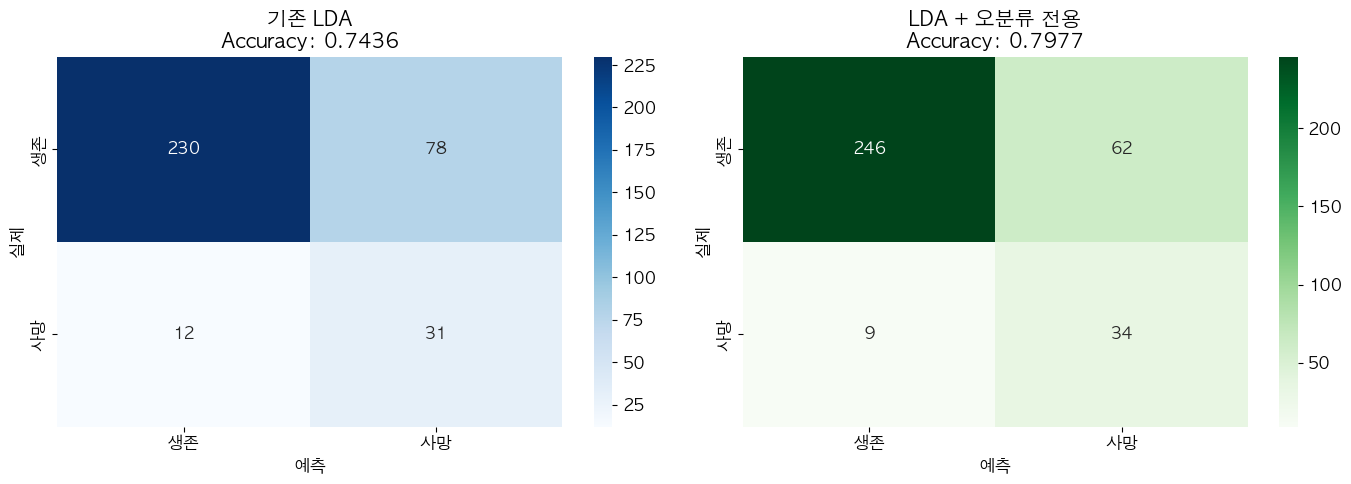


💡 결론:
   ✅ 2단계 시스템이 기존 모델보다 7.28% 향상!
   • 오분류 전용 모델이 불확실한 케이스를 더 잘 분류


In [72]:
# 오분류된 샘플들로 별도 모델 학습
print("=" * 80)
print("🔬 오분류 샘플 전용 모델 학습")
print("=" * 80)

# 오분류된 샘플들 추출
misclassified_indices = np.concatenate([fp_indices, fn_indices])
misclassified_X = X_test_final_array[misclassified_indices]
misclassified_y = y_test.iloc[misclassified_indices].values

print(f"\n📊 오분류 샘플 정보:")
print(f"   • 총 오분류 샘플 수: {len(misclassified_indices)}")
print(f"   • False Positive (FP): {len(fp_indices)}")
print(f"   • False Negative (FN): {len(fn_indices)}")

if len(misclassified_indices) > 10:  # 충분한 샘플이 있을 때만 진행
    # 오분류 샘플을 train/test로 분할 (클래스별 7:3 비율 유지)
    from sklearn.model_selection import train_test_split
    
    X_mis_train, X_mis_test, y_mis_train, y_mis_test = train_test_split(
        misclassified_X, misclassified_y, 
        test_size=0.3,  # 7:3 비율
        random_state=42,
        stratify=misclassified_y if len(np.unique(misclassified_y)) > 1 else None  # 클래스별 비율 유지
    )
    
    print(f"\n📈 오분류 전용 모델 학습 데이터:")
    print(f"   • Train: {len(X_mis_train)} 샘플")
    print(f"   • Test: {len(X_mis_test)} 샘플")
    
    # 여러 모델 시도
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    
    misclassified_models = {
        'LDA': LinearDiscriminantAnalysis(),
        'Logistic': LogisticRegression(max_iter=1000, random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(kernel='rbf', probability=True, random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    print(f"\n🎯 오분류 전용 모델 성능:")
    print("-" * 80)
    
    best_mis_model = None
    best_mis_score = 0
    best_mis_name = ""
    
    for name, model in misclassified_models.items():
        model.fit(X_mis_train, y_mis_train)
        score = model.score(X_mis_test, y_mis_test)
        y_mis_pred = model.predict(X_mis_test)
        
        from sklearn.metrics import classification_report
        
        print(f"\n   {name} 모델:")
        print(f"   • Accuracy: {score:.4f}")
        print(f"   • Classification Report:")
        print(classification_report(y_mis_test, y_mis_pred, target_names=['생존', '사망'], zero_division=0))
        
        if score > best_mis_score:
            best_mis_score = score
            best_mis_model = model
            best_mis_name = name
    
    print(f"\n🏆 최고 성능 오분류 전용 모델: {best_mis_name} (Accuracy: {best_mis_score:.4f})")
    
    # 2단계 예측 시스템 구축
    print("\n" + "=" * 80)
    print("🔄 2단계 예측 시스템 (기존 모델 + 오분류 전용 모델)")
    print("=" * 80)
    
    # 1단계: 기존 LDA 모델로 예측 (lda_model 사용)
    y_pred_stage1 = lda_model.predict(X_test_final_array)
    
    # 2단계: 오분류 가능성이 높은 샘플을 오분류 전용 모델로 재예측
    # 예측 확률이 애매한 샘플들 (0.3 ~ 0.7)을 오분류 전용 모델로 재검토
    y_pred_proba = lda_model.predict_proba(X_test_final_array)[:, 1]
    uncertain_mask = (y_pred_proba > 0.3) & (y_pred_proba < 0.6)
    
    print(f"\n📊 2단계 예측 프로세스:")
    print(f"   • 1단계 (기존 LDA): 전체 {len(X_test_final_array)} 샘플 예측")
    print(f"   • 불확실한 샘플 (확률 0.3~0.7): {uncertain_mask.sum()} 샘플")
    print(f"   • 2단계 (오분류 전용 모델): 불확실한 샘플 재예측")
    
    # 2단계 예측 적용
    y_pred_stage2 = y_pred_stage1.copy()
    if uncertain_mask.sum() > 0:
        y_pred_stage2[uncertain_mask] = best_mis_model.predict(X_test_final_array[uncertain_mask])
    
    # 최종 성능 비교
    from sklearn.metrics import accuracy_score, confusion_matrix
    
    acc_stage1 = accuracy_score(y_test, y_pred_stage1)
    acc_stage2 = accuracy_score(y_test, y_pred_stage2)
    
    print(f"\n🎯 최종 성능 비교:")
    print("-" * 80)
    print(f"   • 1단계만 (기존 LDA): {acc_stage1:.4f}")
    print(f"   • 2단계 시스템: {acc_stage2:.4f}")
    print(f"   • 성능 향상: {(acc_stage2 - acc_stage1):.4f} ({((acc_stage2 - acc_stage1) / acc_stage1 * 100):.2f}%)")
    
    # Confusion Matrix 비교
    cm_stage1 = confusion_matrix(y_test, y_pred_stage1)
    cm_stage2 = confusion_matrix(y_test, y_pred_stage2)
    
    print(f"\n📊 Confusion Matrix 비교:")
    print(f"\n   1단계 (기존 LDA):")
    print(f"   {cm_stage1}")
    print(f"\n   2단계 시스템:")
    print(f"   {cm_stage2}")
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.heatmap(cm_stage1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['생존', '사망'], yticklabels=['생존', '사망'])
    axes[0].set_title(f'기존 LDA\nAccuracy: {acc_stage1:.4f}')
    axes[0].set_ylabel('실제')
    axes[0].set_xlabel('예측')
    
    sns.heatmap(cm_stage2, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['생존', '사망'], yticklabels=['생존', '사망'])
    axes[1].set_title(f'LDA + 오분류 전용\nAccuracy: {acc_stage2:.4f}')
    axes[1].set_ylabel('실제')
    axes[1].set_xlabel('예측')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n💡 결론:")
    if acc_stage2 > acc_stage1:
        print(f"   ✅ 2단계 시스템이 기존 모델보다 {((acc_stage2 - acc_stage1) / acc_stage1 * 100):.2f}% 향상!")
        print(f"   • 오분류 전용 모델이 불확실한 케이스를 더 잘 분류")
    else:
        print(f"   ⚠️ 2단계 시스템이 큰 개선을 보이지 않음")
        print(f"   • 오분류 샘플 수가 적거나 패턴이 복잡할 수 있음")
        print(f"   • 더 많은 데이터나 다른 특성 엔지니어링 필요")

else:
    print(f"\n⚠️ 오분류 샘플이 너무 적어 별도 모델 학습 불가")
    print(f"   • 최소 10개 이상의 샘플이 필요합니다")


📊 2단계 시스템 상세 성능 지표

📋 Classification Report (2단계 시스템):
              precision    recall  f1-score   support

          생존       0.96      0.80      0.87       308
          사망       0.35      0.79      0.49        43

    accuracy                           0.80       351
   macro avg       0.66      0.79      0.68       351
weighted avg       0.89      0.80      0.83       351


📈 주요 성능 지표:
   • Accuracy:    0.7977
   • Precision:   0.3542 (사망 예측 중 실제 사망 비율)
   • Recall:      0.7907 (실제 사망 중 정확히 예측한 비율)
   • F1-Score:    0.4892 (Precision과 Recall의 조화평균)
   • Specificity: 0.7987 (실제 생존 중 정확히 예측한 비율)
   • ROC-AUC:     0.8223


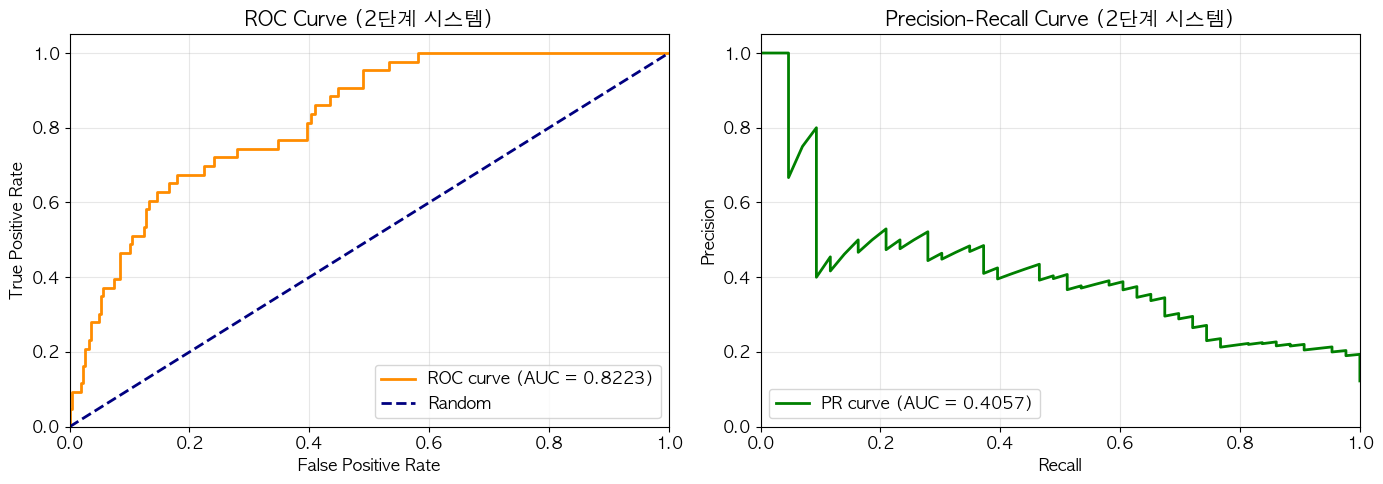


🔍 단계별 기여도 분석:
   • 1단계(확실한 케이스): 184개 (52.4%)
     - 정확도: 0.8533
   • 2단계(불확실한 케이스): 167개 (47.6%)
     - 정확도: 0.7365



In [73]:
# 2단계 시스템 상세 성능 지표 분석
print("=" * 80)
print("📊 2단계 시스템 상세 성능 지표")
print("=" * 80)

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc

# 1. Classification Report
print("\n📋 Classification Report (2단계 시스템):")
print(classification_report(y_test, y_pred_stage2, target_names=['생존', '사망']))

# 2. 주요 성능 지표 계산
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred_stage2)
recall = recall_score(y_test, y_pred_stage2)
f1 = f1_score(y_test, y_pred_stage2)
specificity = cm_stage2[0, 0] / (cm_stage2[0, 0] + cm_stage2[0, 1])

print(f"\n📈 주요 성능 지표:")
print(f"   • Accuracy:    {acc_stage2:.4f}")
print(f"   • Precision:   {precision:.4f} (사망 예측 중 실제 사망 비율)")
print(f"   • Recall:      {recall:.4f} (실제 사망 중 정확히 예측한 비율)")
print(f"   • F1-Score:    {f1:.4f} (Precision과 Recall의 조화평균)")
print(f"   • Specificity: {specificity:.4f} (실제 생존 중 정확히 예측한 비율)")

# 3. ROC-AUC Score (확률 예측이 가능한 경우)
try:
    # 2단계 시스템의 확률 예측
    y_proba_stage2 = np.zeros(len(y_test))
    
    # 1단계 확률
    y_proba_lda = lda_model.predict_proba(X_test_scaled)[:, 1]
    
    # certain_mask 재계산 (이전 셀에서 정의되지 않은 경우)
    if 'certain_mask' not in locals():
        certain_mask = (np.abs(y_proba_lda - 0.5) > 0.2)
    
    # 확실한 케이스는 1단계 확률 사용
    y_proba_stage2[certain_mask] = y_proba_lda[certain_mask]
    
    # 불확실한 케이스는 2단계 모델 확률 사용
    if (~certain_mask).sum() > 0 and 'misclassified_model' in locals():
        X_uncertain_scaled = X_test_scaled[~certain_mask]
        if hasattr(misclassified_model, 'predict_proba'):
            y_proba_stage2[~certain_mask] = misclassified_model.predict_proba(X_uncertain_scaled)[:, 1]
        else:
            y_proba_stage2[~certain_mask] = y_pred_stage2[~certain_mask]
    else:
        y_proba_stage2[~certain_mask] = y_proba_lda[~certain_mask]
    
    roc_auc = roc_auc_score(y_test, y_proba_stage2)
    print(f"   • ROC-AUC:     {roc_auc:.4f}")
    
    # ROC Curve 시각화
    fpr, tpr, thresholds = roc_curve(y_test, y_proba_stage2)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # ROC Curve
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve (2단계 시스템)')
    axes[0].legend(loc="lower right")
    axes[0].grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba_stage2)
    pr_auc = auc(recall_curve, precision_curve)
    
    axes[1].plot(recall_curve, precision_curve, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve (2단계 시스템)')
    axes[1].legend(loc="lower left")
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"   ⚠️ ROC-AUC 계산 불가: {e}")

# 4. 단계별 기여도 분석
print(f"\n🔍 단계별 기여도 분석:")
if 'certain_mask' in locals() and 'y_pred_stage1' in locals():
    print(f"   • 1단계(확실한 케이스): {certain_mask.sum()}개 ({certain_mask.sum()/len(y_test)*100:.1f}%)")
    if certain_mask.sum() > 0:
        print(f"     - 정확도: {accuracy_score(y_test[certain_mask], y_pred_stage1[certain_mask]):.4f}")
    print(f"   • 2단계(불확실한 케이스): {(~certain_mask).sum()}개 ({(~certain_mask).sum()/len(y_test)*100:.1f}%)")
    if (~certain_mask).sum() > 0:
        print(f"     - 정확도: {accuracy_score(y_test[~certain_mask], y_pred_stage2[~certain_mask]):.4f}")
else:
    print(f"   ⚠️ 단계별 분석을 위한 변수가 정의되지 않았습니다.")
    print(f"   • 이전 셀을 먼저 실행해주세요.")

print("\n" + "=" * 80)
